<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project1_dedalus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solving the diffusion equation with Dedalus

**Overview:** This notebook solves the diffusion equation using a spectral method and provides an introduction to Dedalus.

**About Dedalus:** [Dedalus](http://dedalus-project.org) is an open-source Python package for solving partial differential equations (PDEs) using spectral methods.
These methods provide highly accurate numerical solutions for PDEs with smooth solutions in simple domains like boxes and spheres.
Dedalus implements modern parallel algorithms utilizing sparse polynomial bases, but all with an easy-to-use symbolic interface.
The code is being used in a wide range of fields, often for problems involving fluid dynamics.

This script is based in part on the Introduction to Dedalus by [Keaton Burns](http://keaton-burns.com)

The student exercise starts in [Section 5](#student_investigation)

# 1. Setup

First, we need to install Dedalus.  If you are running Python on your local computer, follow the install instructions in the [Dedalus Docs](https://dedalus-project.readthedocs.io/en/latest/pages/installation.html) to install Dedalus locally on your computer.

The cell below checks to see if Dedalus is installed.  After installing Dedalus, run the cell below to verify that Dedalus is installed correctly.

If you are using Google Colab, the cell below will automatically install Dedalus.

This cell checks if Dedalus is installed and performs some other basic setup. This will take some time the first time you run it.

Once you have Dedalus installed, you won't need to run this cell again.

In [24]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install cython "mpi4py<4.0" numpy setuptools wheel
        !CC=mpicc pip3 install --no-cache --no-build-isolation http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus already installed :)


At the start of each Python script, we need to import the packages that we will use.  The cell below imports the packages that will be needed here, namely numpy, matplotlib (for plotting) and dedalus. Note that we assign aliases for numpy, matplotlib, and dedlaus. Run this cell before running any of the cells below.

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

## 2. Dedalus basics

Dedalus solves PDEs using spectral methods.  Dedalus requires us to specify the spatial coordinates, the `distributor`, and the spectral bases, which are explained below.

### Coordinates

We can use a variety of coordinate systems in Dedalus. For example, for multi-dimensional problems, we can use Cartesian coordinates, polar coordinates, spherical coordinates, etc. Here, we will set up a 1D problem using the Dedalus `Coordinate` class. We will see other examples in future projects.
For more details on other problem types, included distributed parallel simulations, see the official [Dedalus Tutorial 1](https://dedalus-project.readthedocs.io/en/latest/notebooks/dedalus_tutorial_1.html).

Let's create a coordinate object representing our 1D coordinate, which here we will call `x`:

In [26]:
xcoord = dedalus.Coordinate('x')

### Distributors

Dedalus uses MPI (Message Passing Interface) for allow parallel computation on distributed memory systems. There are various options for how to distribute the computation amongst the processes. In Dedalus this is done by an object called a `Distributor`. Here, we will run not run in paralle, but Dedalus still requies us to create a `Distributor` object. You don't need to worry about this now, we will discuss it further in later projects.

The line below creates a distributor for our x coordinate for a problem with real variables.

In [27]:
dist = dedalus.Distributor(xcoord, dtype=np.float64) # No mesh for serial / automatic parallelization

### Spectral basis

Dedalus decomposes the PDE that we are solving using a spectral basis. Dedalus has the ability to use different basis functions for this decomposition, and this gives Dedalus remarkable flexibility. For example, `RealFourier` provides a Fouier basis (sine and cosine functions) can be used for problems that are periodic (cyclic) in physical space. The `Chebyshev` basis allows boundary conditions to be set on a finite interval. The `SphereBasis` allows us to solve problems on a sphere.

The line below creates a Fourier basis for a real-valued system with a domain size of Lx=10 and with Nx=1024 gridpoints in physical space.

In [28]:
# Set some parameters
Nx = 1024 # The number of gridpoints. Note that Fourier transforms are more efficient if this is a power of 2
x_start=-1; x_end=1 # The starting and ending bounds on x

# Construct a Fourier basis
x_basis = dedalus.RealFourier(xcoord, size=Nx, bounds=(x_start, x_end))

### Grids

Each basis has a corresponding grid in physical space that can be used for tasks like initializing and plotting fields.

The line below creates a grid for the x coordinate.


In [29]:
x = dist.local_grid(x_basis)

### Fields

`Field` objects in Dedalus represent scalar-valued fields defined over a set of bases (or a "domain").
For multidimensional problems, vector and tensor valued fields can also be constructed using the `VectorField` and `TensorField` clases.

Let's construct a field called `c` (for concentration) using our 1D basis:

In [30]:
c = dist.Field(name='c', bases=x_basis)

Field objects have internal methods for transforming their data between grid (`'g'`) and coefficeint (`'c'`) space representations.
The field's values can be assigned and retrieved by indexing a field with these strings.

Let's set the grid-space values of our field, `c`, to be a Gaussian function of `x`. This is how we set the initial condition for the initial value problem that we will solve below.

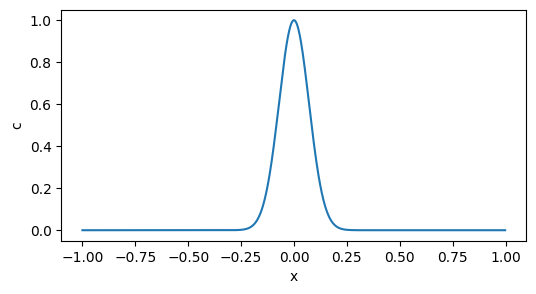

In [31]:
w = 0.1 # Set the width of the initial Gaussian
c.change_scales(1) # Set values on regular grid
c['g'] = np.exp(-x**2/w**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)

plt.figure(figsize=(6, 3)) # Set the size of the figure
plt.plot(x, c['g']) # Plot the "grid-space" initial conditions
plt.xlabel('x'); plt.ylabel("c"); # Set the axis labels

As a bit of an aside, we can find the coefficients of the spectral representation of a field using ['c'] instead of ['g'].
This triggers an in-place spectral (in this case Fourier) transform of the field's data.
For the `RealFourier` basis, the coefficients are the interleaved real-valued coefficients of the cosine and (negative) sine coefficients.
For very large problems transforming between grid and coefficient space will be time-consuming, so you will want to limit the number of times that this is done.

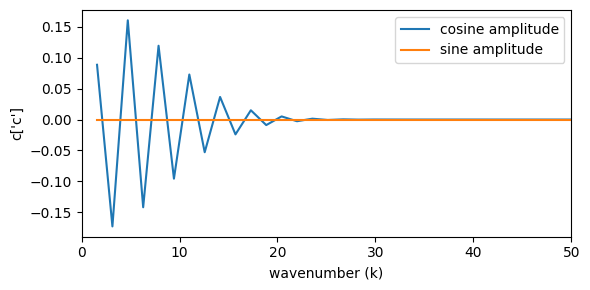

In [32]:
k = np.pi * np.arange(1, Nx/2+1) / (x_end - x_start) # Create an array of wavenumbers, k(i)=i*pi/Lx
plt.figure(figsize=(6, 3))
plt.plot(k, c['c'][0::2], label='cosine amplitude')
plt.plot(k, -c['c'][1::2], label='sine amplitude')
plt.xlabel('wavenumber (k)')
plt.ylabel("c['c']")
plt.xlim(0, 50)
plt.legend()
plt.tight_layout()

## 3. Problems and Solvers

Dedalus uses Problem and Solver classes to specify the problem and the methods that will be used to solve it. Here, we will set up the diffusion equation and solve it using the Crank-Nicolson timestepping method.

For more details on other problem types, see [Dedalus Tutorial 3](https://dedalus-project.readthedocs.io/en/latest/notebooks/dedalus_tutorial_2.html).

### Problems

Dedalus standardizes the formulation of all initial value problems by taking systems of symbolically specified equations and boundary conditions specified in the following generic form:

$$\mathcal{M} \cdot \partial_t \mathcal{X} + \mathcal{L} \cdot \mathcal{X} = \mathcal{F}(\mathcal{X}, t)$$

where $\mathcal{M}$ and $\mathcal{L}$ are matrices of linear differential operators, $\mathcal{X}$ is a state vector of the unknown fields, $\mathcal{F}$ is a vector of general nonlinear expressions.

The left-hand side (LHS) of the equations must be first-order in temporal derivatives and linear in the problem variables.
The right-hand side (RHS) of the equations may contain nonlinear and time-dependent terms, but no temporal derivatives.

When using a mixed implicit/explicit timestepping scheme, Dedalus will apply the implicit method to the $\mathcal{L}\cdot \mathcal{X}$ term and the explicit method to the $\mathcal{F}(\mathcal{X}, t)$ term.

To create a problem object, we provide a list of the variables to be solved for. In this case, this is just `c`.

Equations can then be entered as pairs of operator expressions like `(LHS, RHS)` or as strings like `"LHS = RHS"`.

Here, let's set up the diffusion equation:

$$\partial_t c - \kappa \partial_x^2 c = 0$$

Note that we put the term with the second derivative on the left hand side of the equation so that it will be time-stepped implicitly.

In [33]:
# Parameters
kappa = 0.001

# Operators
dx = lambda a: dedalus.Differentiate(a, xcoord) # Define the derivative (d/dx) operator

# Specify the problem
problem = dedalus.IVP([c], namespace=locals()) # Initial value problem, including all local variables
problem.add_equation("dt(c) - kappa*dx(dx(c)) = 0"); # Write out the equation to be solved


### 3.2 Solvers

Now, we need to specify the solver.  For IVPs, we specify a timestepping method when building the solver. Below we select the `CNAB1` timestepper which uses Crank-Nicolson for the $\mathcal{L}\cdot \mathcal{X}$ term and the explicit first order Adams-Bashforth method for the right hand side term (but in this case the RHS is zero).

In [34]:
timestepper = dedalus.CNAB1
solver = problem.build_solver(timestepper)

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


2024-12-15 23:06:57,161 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


Next, we need to specify a condition for the simulation to end. This can be a set number of iterations (set using `solver.stop_iteration`), a stopping time in simulation time units (set using `solver.stop_sim_time`, or a maximum wall clock time in seconds (set using `solver.stop_wall_time`).



In [35]:
solver.stop_sim_time = 10 # Stop at 10 simulation time units

IVPs are iterated using the `solver.step` method with a provided timestep.
The logic controlling the main-loop of a Dedalus IVP simulation occurs explicitly in the simulation script.
The `solver.proceed` property will change from `True` to `False` once any of the specified stopping criteria have been met.
Let's timestep our problem until the halting condition is reached, copying the grid values of `u` every few iterations.
This should take just a few seconds to run.

In [36]:
# Main loop
timestep = 0.1
c.change_scales(1)
c_save = [np.copy(c['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
while solver.proceed:
    solver.step(timestep)
    if solver.iteration % 500 == 0: # Every 500 timesteps, print a message to the screen with the progress
        logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
    # save the values of c and t
    c.change_scales(1)
    c_save.append(np.copy(c['g']))
    t_save.append(solver.sim_time)

INFO:solvers:Simulation stop time reached.


2024-12-15 23:06:57,236 solvers 0/1 INFO :: Simulation stop time reached.


Now we can make a space-time plot of the solution:

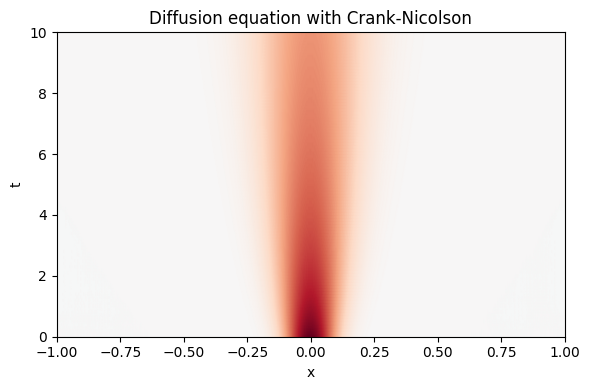

In [37]:
# Plot
plt.figure(figsize=(6, 4))
plt.pcolormesh(x.ravel(), np.array(t_save), np.array(c_save), cmap='RdBu_r', shading='gouraud', rasterized=True, clim=(-1, 1))
plt.xlim(x_start, x_end)
plt.ylim(0, solver.stop_sim_time)
plt.xlabel('x')
plt.ylabel('t')
plt.title(f'Diffusion equation with Crank-Nicolson')
plt.tight_layout()

## 4. Forced diffusion equation

Dedalus is extremely flexible, which will make it very useful throughout the QCES computational projects. For example, it is relatively straightforward to change the equation that we are solving.

In order to introduce functions into the equations that Dedalus solves, we need to define a new operator.  For example, the following code defines the function $sin(x)$ on our grid:

In [38]:
# Create an operator that applies a function to the variable on a grid
sin_x = dist.Field(bases=x_basis)
sin_x['g'] = np.sin(x)

The code below uses Dedlaus to solve the forced diffusion equation:

$$\partial_t c - \kappa \partial_x^2 c = cos(\pi x / Lx)$$

with the same Gaussian initial condition as before. This example also shows what a complete Dedalus script looks like.

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.9e+01/s


2024-12-15 23:06:59,006 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.9e+01/s


INFO:solvers:Simulation stop time reached.


2024-12-15 23:06:59,056 solvers 0/1 INFO :: Simulation stop time reached.


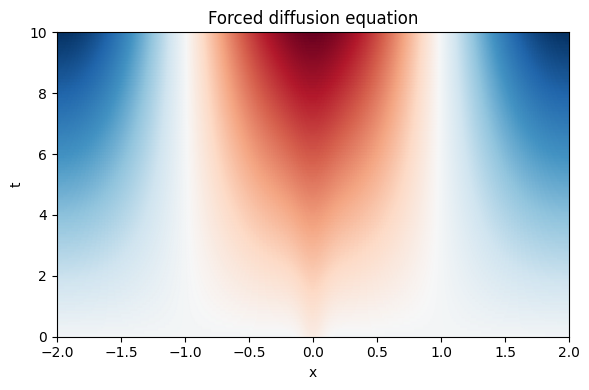

In [39]:
# Load the required packages (these were loaded above and are inluded here for completeness)
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# This script solves the forced diffusion equation with Dedlaus

# Set some parameters for the problem to be solved
Nx = 1024 # The number of gridpoints. Note that Fourier transforms are more efficient if this is a power of 2
Lx = 2; # The domain size in x.  This should be large enough so that the solution goes to zero at the endpoints.
x_start=-Lx; x_end=Lx # The starting and ending bounds on x
kappa = 0.001 # set the diffusivity

# Create an x-coordinate, a corresponding basis, and a distributor
xcoord = dedalus.Coordinate('x')
dist = dedalus.Distributor(xcoord, dtype=np.float64) # No mesh for serial / automatic parallelization
x_basis = dedalus.RealFourier(xcoord, size=Nx, bounds=(x_start, x_end))
x = dist.local_grid(x_basis)

# Set initial conditions
c = dist.Field(name='c', bases=x_basis)
w = 0.1 # Set the width of the initial Gaussian
c.change_scales(1) # Set values on regular grid
c['g'] = np.exp(-x**2/w**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)

# Operators
dx = lambda a: dedalus.Differentiate(a, xcoord) # Define the derivative (d/dx) operator

# Create an operator that applies a function to the variable on a grid
f_x = dist.Field(bases=x_basis)
f_x['g'] = np.cos(np.pi * x / Lx)

# Specify the problem
problem = dedalus.IVP([c], namespace=locals()) # Initial value problem, including all local variables
problem.add_equation("dt(c) - kappa * dx(dx(c)) = f_x"); # Write out the equation to be solved

timestepper = dedalus.CNAB1
solver = problem.build_solver(timestepper)

solver.stop_sim_time = 10 # Stop at 10 simulation time units

# Main loop
timestep = 0.1
c.change_scales(1)
c_save = [np.copy(c['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
while solver.proceed:
    solver.step(timestep)
    if solver.iteration % 500 == 0: # Every 500 timesteps, print a message to the screen with the progress
        logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
    c.change_scales(1)
    c_save.append(np.copy(c['g']))
    t_save.append(solver.sim_time)

# Plot
plt.figure(figsize=(6, 4))
plt.pcolormesh(x.ravel(), np.array(t_save), np.array(c_save), cmap='RdBu_r', shading='gouraud', rasterized=True)#, clim=(-1, 1))
plt.xlim(x_start, x_end)
plt.ylim(0, solver.stop_sim_time)
plt.xlabel('x')
plt.ylabel('t')
plt.title('Forced diffusion equation')
plt.tight_layout()

## 5. Student investigation
<a id='student_investigation'></a>

### 5.1 Steady-state solution to the forced diffusion equation

For the forced diffusion equation described in section 4, using dimensional analysis, estimate the time needed to reach a steady-state solution. Test this scaling, and discuss your results below. Run the code above for a sufficient time to achieve a steady-state solution. Plot $c$ at the end of this simulation, and compare it with the exact steady-state solution to the forced diffusion equation.

Students should comment on the timescale needed to transition from the initial condition to the forced solution, and comment on the diffusive and forcing timescales.

# **[Unjin]  이부분만다시**

The time needed to reach a steady-state solution can be derived as follows using scaling analysis. Let $c = c^{*} \times C$, $t = t^{*} \times T$, $\kappa = \kappa^{*} \times K$, $x = x^{*} \times L$, where $c^{*}$, $t^{*}$, $\kappa^{*}$ and $x^{*}$ are numbers and $C$, $T$, $K$ and $L$ are units(dimensions). From the forced diffusion equation, we know $\frac{C}{T} \sim K*\frac{C}{L^{2}}$, i.e., $T \sim \frac{L^{2}}{K}$. Therefore, the time needed to reach a steady state solution is $t = \frac{2^2}{0.001} = 4,000$.

To test if $t=4,000$ is truly the time needed for the system to reach equilibrium, I plotted a graph of the concentration at $x=0.5$ over time, and it seems that around $t=4,000$, the system reaches equilibrium.

The exact steady state solution, $c(x, t)$ to the forced equation given above has a form of $c(x, t) = c_h(x, t) + c_p(x)$, where $c_h(x, t) = \sum_{n=1}^\infty A_n e^{-\kappa \left(\frac{n\pi}{L_x}\right)^2 t} \sin\left(\frac{n\pi x}{L_x}\right)$ and $c_p(x) = \frac{1}{\kappa} \frac{L_x^2}{\pi^2} \cos\left(\frac{\pi x}{L_x}\right) + \frac{C_1}{\kappa}x + \frac{C_2}{\kappa}$.


Let us fix x at 0.5 and draw two plots of $c$ as a function of $t$ using the Dedalus script and the exact steady-state solution, respectively.

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.7e+01/s


2024-12-15 23:10:38,362 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.7e+01/s


INFO:__main__:Iteration=500, Time=5.000000e+01, dt=1.000000e-01


2024-12-15 23:10:38,515 __main__ 0/1 INFO :: Iteration=500, Time=5.000000e+01, dt=1.000000e-01


INFO:__main__:Iteration=1000, Time=1.000000e+02, dt=1.000000e-01


2024-12-15 23:10:38,662 __main__ 0/1 INFO :: Iteration=1000, Time=1.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=1500, Time=1.500000e+02, dt=1.000000e-01


2024-12-15 23:10:38,932 __main__ 0/1 INFO :: Iteration=1500, Time=1.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=2000, Time=2.000000e+02, dt=1.000000e-01


2024-12-15 23:10:39,167 __main__ 0/1 INFO :: Iteration=2000, Time=2.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=2500, Time=2.500000e+02, dt=1.000000e-01


2024-12-15 23:10:39,417 __main__ 0/1 INFO :: Iteration=2500, Time=2.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=3000, Time=3.000000e+02, dt=1.000000e-01


2024-12-15 23:10:39,651 __main__ 0/1 INFO :: Iteration=3000, Time=3.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=3500, Time=3.500000e+02, dt=1.000000e-01


2024-12-15 23:10:39,871 __main__ 0/1 INFO :: Iteration=3500, Time=3.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=4000, Time=4.000000e+02, dt=1.000000e-01


2024-12-15 23:10:40,103 __main__ 0/1 INFO :: Iteration=4000, Time=4.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=4500, Time=4.500000e+02, dt=1.000000e-01


2024-12-15 23:10:40,322 __main__ 0/1 INFO :: Iteration=4500, Time=4.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=5000, Time=5.000000e+02, dt=1.000000e-01


2024-12-15 23:10:40,555 __main__ 0/1 INFO :: Iteration=5000, Time=5.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=5500, Time=5.500000e+02, dt=1.000000e-01


2024-12-15 23:10:40,772 __main__ 0/1 INFO :: Iteration=5500, Time=5.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=6000, Time=6.000000e+02, dt=1.000000e-01


2024-12-15 23:10:41,008 __main__ 0/1 INFO :: Iteration=6000, Time=6.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=6500, Time=6.500000e+02, dt=1.000000e-01


2024-12-15 23:10:41,262 __main__ 0/1 INFO :: Iteration=6500, Time=6.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=7000, Time=7.000000e+02, dt=1.000000e-01


2024-12-15 23:10:41,491 __main__ 0/1 INFO :: Iteration=7000, Time=7.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=7500, Time=7.500000e+02, dt=1.000000e-01


2024-12-15 23:10:41,744 __main__ 0/1 INFO :: Iteration=7500, Time=7.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=8000, Time=8.000000e+02, dt=1.000000e-01


2024-12-15 23:10:41,981 __main__ 0/1 INFO :: Iteration=8000, Time=8.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=8500, Time=8.500000e+02, dt=1.000000e-01


2024-12-15 23:10:42,264 __main__ 0/1 INFO :: Iteration=8500, Time=8.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=9000, Time=9.000000e+02, dt=1.000000e-01


2024-12-15 23:10:42,519 __main__ 0/1 INFO :: Iteration=9000, Time=9.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=9500, Time=9.500000e+02, dt=1.000000e-01


2024-12-15 23:10:42,701 __main__ 0/1 INFO :: Iteration=9500, Time=9.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=10000, Time=1.000000e+03, dt=1.000000e-01


2024-12-15 23:10:42,847 __main__ 0/1 INFO :: Iteration=10000, Time=1.000000e+03, dt=1.000000e-01


INFO:__main__:Iteration=10500, Time=1.050000e+03, dt=1.000000e-01


2024-12-15 23:10:42,984 __main__ 0/1 INFO :: Iteration=10500, Time=1.050000e+03, dt=1.000000e-01


INFO:__main__:Iteration=11000, Time=1.100000e+03, dt=1.000000e-01


2024-12-15 23:10:43,162 __main__ 0/1 INFO :: Iteration=11000, Time=1.100000e+03, dt=1.000000e-01


INFO:__main__:Iteration=11500, Time=1.150000e+03, dt=1.000000e-01


2024-12-15 23:10:43,303 __main__ 0/1 INFO :: Iteration=11500, Time=1.150000e+03, dt=1.000000e-01


INFO:__main__:Iteration=12000, Time=1.200000e+03, dt=1.000000e-01


2024-12-15 23:10:43,448 __main__ 0/1 INFO :: Iteration=12000, Time=1.200000e+03, dt=1.000000e-01


INFO:__main__:Iteration=12500, Time=1.250000e+03, dt=1.000000e-01


2024-12-15 23:10:43,597 __main__ 0/1 INFO :: Iteration=12500, Time=1.250000e+03, dt=1.000000e-01


INFO:__main__:Iteration=13000, Time=1.300000e+03, dt=1.000000e-01


2024-12-15 23:10:43,738 __main__ 0/1 INFO :: Iteration=13000, Time=1.300000e+03, dt=1.000000e-01


INFO:__main__:Iteration=13500, Time=1.350000e+03, dt=1.000000e-01


2024-12-15 23:10:43,878 __main__ 0/1 INFO :: Iteration=13500, Time=1.350000e+03, dt=1.000000e-01


INFO:__main__:Iteration=14000, Time=1.400000e+03, dt=1.000000e-01


2024-12-15 23:10:44,026 __main__ 0/1 INFO :: Iteration=14000, Time=1.400000e+03, dt=1.000000e-01


INFO:__main__:Iteration=14500, Time=1.450000e+03, dt=1.000000e-01


2024-12-15 23:10:44,214 __main__ 0/1 INFO :: Iteration=14500, Time=1.450000e+03, dt=1.000000e-01


INFO:__main__:Iteration=15000, Time=1.500000e+03, dt=1.000000e-01


2024-12-15 23:10:44,362 __main__ 0/1 INFO :: Iteration=15000, Time=1.500000e+03, dt=1.000000e-01


INFO:__main__:Iteration=15500, Time=1.550000e+03, dt=1.000000e-01


2024-12-15 23:10:44,517 __main__ 0/1 INFO :: Iteration=15500, Time=1.550000e+03, dt=1.000000e-01


INFO:__main__:Iteration=16000, Time=1.600000e+03, dt=1.000000e-01


2024-12-15 23:10:44,666 __main__ 0/1 INFO :: Iteration=16000, Time=1.600000e+03, dt=1.000000e-01


INFO:__main__:Iteration=16500, Time=1.650000e+03, dt=1.000000e-01


2024-12-15 23:10:44,813 __main__ 0/1 INFO :: Iteration=16500, Time=1.650000e+03, dt=1.000000e-01


INFO:__main__:Iteration=17000, Time=1.700000e+03, dt=1.000000e-01


2024-12-15 23:10:44,958 __main__ 0/1 INFO :: Iteration=17000, Time=1.700000e+03, dt=1.000000e-01


INFO:__main__:Iteration=17500, Time=1.750000e+03, dt=1.000000e-01


2024-12-15 23:10:45,132 __main__ 0/1 INFO :: Iteration=17500, Time=1.750000e+03, dt=1.000000e-01


INFO:__main__:Iteration=18000, Time=1.800000e+03, dt=1.000000e-01


2024-12-15 23:10:45,293 __main__ 0/1 INFO :: Iteration=18000, Time=1.800000e+03, dt=1.000000e-01


INFO:__main__:Iteration=18500, Time=1.850000e+03, dt=1.000000e-01


2024-12-15 23:10:45,449 __main__ 0/1 INFO :: Iteration=18500, Time=1.850000e+03, dt=1.000000e-01


INFO:__main__:Iteration=19000, Time=1.900000e+03, dt=1.000000e-01


2024-12-15 23:10:45,596 __main__ 0/1 INFO :: Iteration=19000, Time=1.900000e+03, dt=1.000000e-01


INFO:__main__:Iteration=19500, Time=1.950000e+03, dt=1.000000e-01


2024-12-15 23:10:45,737 __main__ 0/1 INFO :: Iteration=19500, Time=1.950000e+03, dt=1.000000e-01


INFO:__main__:Iteration=20000, Time=2.000000e+03, dt=1.000000e-01


2024-12-15 23:10:45,879 __main__ 0/1 INFO :: Iteration=20000, Time=2.000000e+03, dt=1.000000e-01


INFO:__main__:Iteration=20500, Time=2.050000e+03, dt=1.000000e-01


2024-12-15 23:10:46,036 __main__ 0/1 INFO :: Iteration=20500, Time=2.050000e+03, dt=1.000000e-01


INFO:__main__:Iteration=21000, Time=2.100000e+03, dt=1.000000e-01


2024-12-15 23:10:46,219 __main__ 0/1 INFO :: Iteration=21000, Time=2.100000e+03, dt=1.000000e-01


INFO:__main__:Iteration=21500, Time=2.150000e+03, dt=1.000000e-01


2024-12-15 23:10:46,366 __main__ 0/1 INFO :: Iteration=21500, Time=2.150000e+03, dt=1.000000e-01


INFO:__main__:Iteration=22000, Time=2.200000e+03, dt=1.000000e-01


2024-12-15 23:10:46,525 __main__ 0/1 INFO :: Iteration=22000, Time=2.200000e+03, dt=1.000000e-01


INFO:__main__:Iteration=22500, Time=2.250000e+03, dt=1.000000e-01


2024-12-15 23:10:46,672 __main__ 0/1 INFO :: Iteration=22500, Time=2.250000e+03, dt=1.000000e-01


INFO:__main__:Iteration=23000, Time=2.300000e+03, dt=1.000000e-01


2024-12-15 23:10:46,815 __main__ 0/1 INFO :: Iteration=23000, Time=2.300000e+03, dt=1.000000e-01


INFO:__main__:Iteration=23500, Time=2.350000e+03, dt=1.000000e-01


2024-12-15 23:10:46,966 __main__ 0/1 INFO :: Iteration=23500, Time=2.350000e+03, dt=1.000000e-01


INFO:__main__:Iteration=24000, Time=2.400000e+03, dt=1.000000e-01


2024-12-15 23:10:47,136 __main__ 0/1 INFO :: Iteration=24000, Time=2.400000e+03, dt=1.000000e-01


INFO:__main__:Iteration=24500, Time=2.450000e+03, dt=1.000000e-01


2024-12-15 23:10:47,295 __main__ 0/1 INFO :: Iteration=24500, Time=2.450000e+03, dt=1.000000e-01


INFO:__main__:Iteration=25000, Time=2.500000e+03, dt=1.000000e-01


2024-12-15 23:10:47,443 __main__ 0/1 INFO :: Iteration=25000, Time=2.500000e+03, dt=1.000000e-01


INFO:__main__:Iteration=25500, Time=2.550000e+03, dt=1.000000e-01


2024-12-15 23:10:47,589 __main__ 0/1 INFO :: Iteration=25500, Time=2.550000e+03, dt=1.000000e-01


INFO:__main__:Iteration=26000, Time=2.600000e+03, dt=1.000000e-01


2024-12-15 23:10:47,736 __main__ 0/1 INFO :: Iteration=26000, Time=2.600000e+03, dt=1.000000e-01


INFO:__main__:Iteration=26500, Time=2.650000e+03, dt=1.000000e-01


2024-12-15 23:10:47,874 __main__ 0/1 INFO :: Iteration=26500, Time=2.650000e+03, dt=1.000000e-01


INFO:__main__:Iteration=27000, Time=2.700000e+03, dt=1.000000e-01


2024-12-15 23:10:48,035 __main__ 0/1 INFO :: Iteration=27000, Time=2.700000e+03, dt=1.000000e-01


INFO:__main__:Iteration=27500, Time=2.750000e+03, dt=1.000000e-01


2024-12-15 23:10:48,202 __main__ 0/1 INFO :: Iteration=27500, Time=2.750000e+03, dt=1.000000e-01


INFO:__main__:Iteration=28000, Time=2.800000e+03, dt=1.000000e-01


2024-12-15 23:10:48,363 __main__ 0/1 INFO :: Iteration=28000, Time=2.800000e+03, dt=1.000000e-01


INFO:__main__:Iteration=28500, Time=2.850000e+03, dt=1.000000e-01


2024-12-15 23:10:48,509 __main__ 0/1 INFO :: Iteration=28500, Time=2.850000e+03, dt=1.000000e-01


INFO:__main__:Iteration=29000, Time=2.900000e+03, dt=1.000000e-01


2024-12-15 23:10:48,657 __main__ 0/1 INFO :: Iteration=29000, Time=2.900000e+03, dt=1.000000e-01


INFO:__main__:Iteration=29500, Time=2.950000e+03, dt=1.000000e-01


2024-12-15 23:10:48,799 __main__ 0/1 INFO :: Iteration=29500, Time=2.950000e+03, dt=1.000000e-01


INFO:__main__:Iteration=30000, Time=3.000000e+03, dt=1.000000e-01


2024-12-15 23:10:48,945 __main__ 0/1 INFO :: Iteration=30000, Time=3.000000e+03, dt=1.000000e-01


INFO:__main__:Iteration=30500, Time=3.050000e+03, dt=1.000000e-01


2024-12-15 23:10:49,111 __main__ 0/1 INFO :: Iteration=30500, Time=3.050000e+03, dt=1.000000e-01


INFO:__main__:Iteration=31000, Time=3.100000e+03, dt=1.000000e-01


2024-12-15 23:10:49,265 __main__ 0/1 INFO :: Iteration=31000, Time=3.100000e+03, dt=1.000000e-01


INFO:__main__:Iteration=31500, Time=3.150000e+03, dt=1.000000e-01


2024-12-15 23:10:49,426 __main__ 0/1 INFO :: Iteration=31500, Time=3.150000e+03, dt=1.000000e-01


INFO:__main__:Iteration=32000, Time=3.200000e+03, dt=1.000000e-01


2024-12-15 23:10:49,574 __main__ 0/1 INFO :: Iteration=32000, Time=3.200000e+03, dt=1.000000e-01


INFO:__main__:Iteration=32500, Time=3.250000e+03, dt=1.000000e-01


2024-12-15 23:10:49,718 __main__ 0/1 INFO :: Iteration=32500, Time=3.250000e+03, dt=1.000000e-01


INFO:__main__:Iteration=33000, Time=3.300000e+03, dt=1.000000e-01


2024-12-15 23:10:49,862 __main__ 0/1 INFO :: Iteration=33000, Time=3.300000e+03, dt=1.000000e-01


INFO:__main__:Iteration=33500, Time=3.350000e+03, dt=1.000000e-01


2024-12-15 23:10:50,012 __main__ 0/1 INFO :: Iteration=33500, Time=3.350000e+03, dt=1.000000e-01


INFO:__main__:Iteration=34000, Time=3.400000e+03, dt=1.000000e-01


2024-12-15 23:10:50,176 __main__ 0/1 INFO :: Iteration=34000, Time=3.400000e+03, dt=1.000000e-01


INFO:__main__:Iteration=34500, Time=3.450000e+03, dt=1.000000e-01


2024-12-15 23:10:50,328 __main__ 0/1 INFO :: Iteration=34500, Time=3.450000e+03, dt=1.000000e-01


INFO:__main__:Iteration=35000, Time=3.500000e+03, dt=1.000000e-01


2024-12-15 23:10:50,490 __main__ 0/1 INFO :: Iteration=35000, Time=3.500000e+03, dt=1.000000e-01


INFO:__main__:Iteration=35500, Time=3.550000e+03, dt=1.000000e-01


2024-12-15 23:10:50,639 __main__ 0/1 INFO :: Iteration=35500, Time=3.550000e+03, dt=1.000000e-01


INFO:__main__:Iteration=36000, Time=3.600000e+03, dt=1.000000e-01


2024-12-15 23:10:50,781 __main__ 0/1 INFO :: Iteration=36000, Time=3.600000e+03, dt=1.000000e-01


INFO:__main__:Iteration=36500, Time=3.650000e+03, dt=1.000000e-01


2024-12-15 23:10:50,927 __main__ 0/1 INFO :: Iteration=36500, Time=3.650000e+03, dt=1.000000e-01


INFO:__main__:Iteration=37000, Time=3.700000e+03, dt=1.000000e-01


2024-12-15 23:10:51,097 __main__ 0/1 INFO :: Iteration=37000, Time=3.700000e+03, dt=1.000000e-01


INFO:__main__:Iteration=37500, Time=3.750000e+03, dt=1.000000e-01


2024-12-15 23:10:51,258 __main__ 0/1 INFO :: Iteration=37500, Time=3.750000e+03, dt=1.000000e-01


INFO:__main__:Iteration=38000, Time=3.800000e+03, dt=1.000000e-01


2024-12-15 23:10:51,421 __main__ 0/1 INFO :: Iteration=38000, Time=3.800000e+03, dt=1.000000e-01


INFO:__main__:Iteration=38500, Time=3.850000e+03, dt=1.000000e-01


2024-12-15 23:10:51,562 __main__ 0/1 INFO :: Iteration=38500, Time=3.850000e+03, dt=1.000000e-01


INFO:__main__:Iteration=39000, Time=3.900000e+03, dt=1.000000e-01


2024-12-15 23:10:51,707 __main__ 0/1 INFO :: Iteration=39000, Time=3.900000e+03, dt=1.000000e-01


INFO:__main__:Iteration=39500, Time=3.950000e+03, dt=1.000000e-01


2024-12-15 23:10:51,857 __main__ 0/1 INFO :: Iteration=39500, Time=3.950000e+03, dt=1.000000e-01


INFO:__main__:Iteration=40000, Time=4.000000e+03, dt=1.000000e-01


2024-12-15 23:10:52,000 __main__ 0/1 INFO :: Iteration=40000, Time=4.000000e+03, dt=1.000000e-01


INFO:__main__:Iteration=40500, Time=4.050000e+03, dt=1.000000e-01


2024-12-15 23:10:52,161 __main__ 0/1 INFO :: Iteration=40500, Time=4.050000e+03, dt=1.000000e-01


INFO:__main__:Iteration=41000, Time=4.100000e+03, dt=1.000000e-01


2024-12-15 23:10:52,320 __main__ 0/1 INFO :: Iteration=41000, Time=4.100000e+03, dt=1.000000e-01


INFO:__main__:Iteration=41500, Time=4.150000e+03, dt=1.000000e-01


2024-12-15 23:10:52,478 __main__ 0/1 INFO :: Iteration=41500, Time=4.150000e+03, dt=1.000000e-01


INFO:__main__:Iteration=42000, Time=4.200000e+03, dt=1.000000e-01


2024-12-15 23:10:52,654 __main__ 0/1 INFO :: Iteration=42000, Time=4.200000e+03, dt=1.000000e-01


INFO:__main__:Iteration=42500, Time=4.250000e+03, dt=1.000000e-01


2024-12-15 23:10:52,897 __main__ 0/1 INFO :: Iteration=42500, Time=4.250000e+03, dt=1.000000e-01


INFO:__main__:Iteration=43000, Time=4.300000e+03, dt=1.000000e-01


2024-12-15 23:10:53,162 __main__ 0/1 INFO :: Iteration=43000, Time=4.300000e+03, dt=1.000000e-01


INFO:__main__:Iteration=43500, Time=4.350000e+03, dt=1.000000e-01


2024-12-15 23:10:53,377 __main__ 0/1 INFO :: Iteration=43500, Time=4.350000e+03, dt=1.000000e-01


INFO:__main__:Iteration=44000, Time=4.400000e+03, dt=1.000000e-01


2024-12-15 23:10:53,599 __main__ 0/1 INFO :: Iteration=44000, Time=4.400000e+03, dt=1.000000e-01


INFO:__main__:Iteration=44500, Time=4.450000e+03, dt=1.000000e-01


2024-12-15 23:10:53,804 __main__ 0/1 INFO :: Iteration=44500, Time=4.450000e+03, dt=1.000000e-01


INFO:__main__:Iteration=45000, Time=4.500000e+03, dt=1.000000e-01


2024-12-15 23:10:54,018 __main__ 0/1 INFO :: Iteration=45000, Time=4.500000e+03, dt=1.000000e-01


INFO:__main__:Iteration=45500, Time=4.550000e+03, dt=1.000000e-01


2024-12-15 23:10:54,250 __main__ 0/1 INFO :: Iteration=45500, Time=4.550000e+03, dt=1.000000e-01


INFO:__main__:Iteration=46000, Time=4.600000e+03, dt=1.000000e-01


2024-12-15 23:10:54,474 __main__ 0/1 INFO :: Iteration=46000, Time=4.600000e+03, dt=1.000000e-01


INFO:__main__:Iteration=46500, Time=4.650000e+03, dt=1.000000e-01


2024-12-15 23:10:54,734 __main__ 0/1 INFO :: Iteration=46500, Time=4.650000e+03, dt=1.000000e-01


INFO:__main__:Iteration=47000, Time=4.700000e+03, dt=1.000000e-01


2024-12-15 23:10:54,964 __main__ 0/1 INFO :: Iteration=47000, Time=4.700000e+03, dt=1.000000e-01


INFO:__main__:Iteration=47500, Time=4.750000e+03, dt=1.000000e-01


2024-12-15 23:10:55,215 __main__ 0/1 INFO :: Iteration=47500, Time=4.750000e+03, dt=1.000000e-01


INFO:__main__:Iteration=48000, Time=4.800000e+03, dt=1.000000e-01


2024-12-15 23:10:55,463 __main__ 0/1 INFO :: Iteration=48000, Time=4.800000e+03, dt=1.000000e-01


INFO:__main__:Iteration=48500, Time=4.850000e+03, dt=1.000000e-01


2024-12-15 23:10:55,703 __main__ 0/1 INFO :: Iteration=48500, Time=4.850000e+03, dt=1.000000e-01


INFO:__main__:Iteration=49000, Time=4.900000e+03, dt=1.000000e-01


2024-12-15 23:10:55,935 __main__ 0/1 INFO :: Iteration=49000, Time=4.900000e+03, dt=1.000000e-01


INFO:__main__:Iteration=49500, Time=4.950000e+03, dt=1.000000e-01


2024-12-15 23:10:56,179 __main__ 0/1 INFO :: Iteration=49500, Time=4.950000e+03, dt=1.000000e-01


INFO:__main__:Iteration=50000, Time=5.000000e+03, dt=1.000000e-01


2024-12-15 23:10:56,417 __main__ 0/1 INFO :: Iteration=50000, Time=5.000000e+03, dt=1.000000e-01


INFO:solvers:Simulation stop time reached.


2024-12-15 23:10:56,423 solvers 0/1 INFO :: Simulation stop time reached.


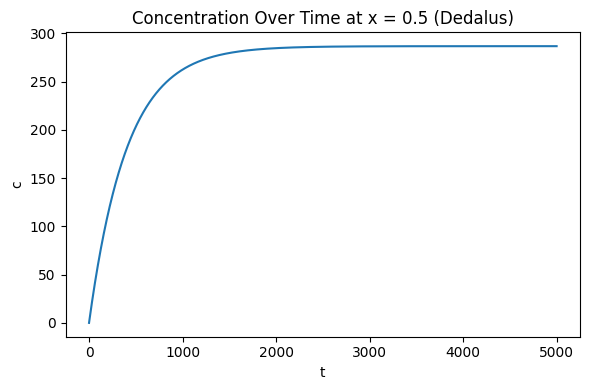

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging

# Dedalus
c_save = []
t_save = []
logger = logging.getLogger(__name__)
Nx = 1024
Lx = 2
kappa = 0.001
x_start=-Lx; x_end=Lx
xcoord = dedalus.Coordinate('x')
dist = dedalus.Distributor(xcoord, dtype=np.float64)
x_basis = dedalus.RealFourier(xcoord, size=Nx, bounds=(x_start, x_end))
x = dist.local_grid(x_basis)
c = dist.Field(name='c', bases=x_basis)
w = 0.1
c.change_scales(1)
c['g'] = np.exp(-x**2/w**2)
dx = lambda a: dedalus.Differentiate(a, xcoord)
f_x = dist.Field(bases=x_basis)
f_x['g'] = np.cos(np.pi * x / Lx)
problem = dedalus.IVP([c], namespace=locals())
problem.add_equation("dt(c) - kappa * dx(dx(c)) = f_x")
timestepper = dedalus.CNAB1
solver = problem.build_solver(timestepper)
solver.stop_sim_time = 5000
timestep = 0.1
c.change_scales(1)
x_focus = 0.5
x_focus_grid = np.argmin(np.abs(x-x_focus))
while solver.proceed:
    solver.step(timestep)
    if solver.iteration % 500 == 0:
        logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
    c.change_scales(1)
    c_save.append(c['g'][x_focus_grid])
    t_save.append(solver.sim_time)
c_save = np.array(c_save)
t_save = np.array(t_save)

plt.figure(figsize=(6, 4))
plt.plot(t_save, c_save)
plt.xlabel('t')
plt.ylabel('c')
plt.title('Concentration Over Time at x = 0.5 (Dedalus)')
plt.tight_layout()
plt.show()

# Exact Solution

In [48]:
# Find the index closest to t = 4000
t_target = 4000
t_idx = np.argmin(np.abs(t_save - t_target))

# Get the corresponding concentration value at x = 0.5
c_at_x_0_5_t_4000 = c_save[t_idx]

print(f"The concentration at t = {t_target} and x = 0.5 is approximately {c_at_x_0_5_t_4000:.6f}")


The concentration at t = 4000 and x = 0.5 is approximately 286.609076


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.7e+01/s


2024-12-15 23:11:11,112 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.7e+01/s


INFO:__main__:Iteration=500, Time=5.000000e+01, dt=1.000000e-01


2024-12-15 23:11:11,260 __main__ 0/1 INFO :: Iteration=500, Time=5.000000e+01, dt=1.000000e-01


INFO:__main__:Iteration=1000, Time=1.000000e+02, dt=1.000000e-01


2024-12-15 23:11:11,415 __main__ 0/1 INFO :: Iteration=1000, Time=1.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=1500, Time=1.500000e+02, dt=1.000000e-01


2024-12-15 23:11:11,561 __main__ 0/1 INFO :: Iteration=1500, Time=1.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=2000, Time=2.000000e+02, dt=1.000000e-01


2024-12-15 23:11:11,832 __main__ 0/1 INFO :: Iteration=2000, Time=2.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=2500, Time=2.500000e+02, dt=1.000000e-01


2024-12-15 23:11:12,185 __main__ 0/1 INFO :: Iteration=2500, Time=2.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=3000, Time=3.000000e+02, dt=1.000000e-01


2024-12-15 23:11:12,576 __main__ 0/1 INFO :: Iteration=3000, Time=3.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=3500, Time=3.500000e+02, dt=1.000000e-01


2024-12-15 23:11:13,097 __main__ 0/1 INFO :: Iteration=3500, Time=3.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=4000, Time=4.000000e+02, dt=1.000000e-01


2024-12-15 23:11:13,494 __main__ 0/1 INFO :: Iteration=4000, Time=4.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=4500, Time=4.500000e+02, dt=1.000000e-01


2024-12-15 23:11:13,864 __main__ 0/1 INFO :: Iteration=4500, Time=4.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=5000, Time=5.000000e+02, dt=1.000000e-01


2024-12-15 23:11:14,252 __main__ 0/1 INFO :: Iteration=5000, Time=5.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=5500, Time=5.500000e+02, dt=1.000000e-01


2024-12-15 23:11:14,705 __main__ 0/1 INFO :: Iteration=5500, Time=5.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=6000, Time=6.000000e+02, dt=1.000000e-01


2024-12-15 23:11:15,079 __main__ 0/1 INFO :: Iteration=6000, Time=6.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=6500, Time=6.500000e+02, dt=1.000000e-01


2024-12-15 23:11:15,578 __main__ 0/1 INFO :: Iteration=6500, Time=6.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=7000, Time=7.000000e+02, dt=1.000000e-01


2024-12-15 23:11:15,843 __main__ 0/1 INFO :: Iteration=7000, Time=7.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=7500, Time=7.500000e+02, dt=1.000000e-01


2024-12-15 23:11:15,985 __main__ 0/1 INFO :: Iteration=7500, Time=7.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=8000, Time=8.000000e+02, dt=1.000000e-01


2024-12-15 23:11:16,163 __main__ 0/1 INFO :: Iteration=8000, Time=8.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=8500, Time=8.500000e+02, dt=1.000000e-01


2024-12-15 23:11:16,313 __main__ 0/1 INFO :: Iteration=8500, Time=8.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=9000, Time=9.000000e+02, dt=1.000000e-01


2024-12-15 23:11:16,471 __main__ 0/1 INFO :: Iteration=9000, Time=9.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=9500, Time=9.500000e+02, dt=1.000000e-01


2024-12-15 23:11:16,611 __main__ 0/1 INFO :: Iteration=9500, Time=9.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=10000, Time=1.000000e+03, dt=1.000000e-01


2024-12-15 23:11:16,761 __main__ 0/1 INFO :: Iteration=10000, Time=1.000000e+03, dt=1.000000e-01


INFO:__main__:Iteration=10500, Time=1.050000e+03, dt=1.000000e-01


2024-12-15 23:11:16,913 __main__ 0/1 INFO :: Iteration=10500, Time=1.050000e+03, dt=1.000000e-01


INFO:__main__:Iteration=11000, Time=1.100000e+03, dt=1.000000e-01


2024-12-15 23:11:17,069 __main__ 0/1 INFO :: Iteration=11000, Time=1.100000e+03, dt=1.000000e-01


INFO:__main__:Iteration=11500, Time=1.150000e+03, dt=1.000000e-01


2024-12-15 23:11:17,243 __main__ 0/1 INFO :: Iteration=11500, Time=1.150000e+03, dt=1.000000e-01


INFO:__main__:Iteration=12000, Time=1.200000e+03, dt=1.000000e-01


2024-12-15 23:11:17,398 __main__ 0/1 INFO :: Iteration=12000, Time=1.200000e+03, dt=1.000000e-01


INFO:__main__:Iteration=12500, Time=1.250000e+03, dt=1.000000e-01


2024-12-15 23:11:17,542 __main__ 0/1 INFO :: Iteration=12500, Time=1.250000e+03, dt=1.000000e-01


INFO:__main__:Iteration=13000, Time=1.300000e+03, dt=1.000000e-01


2024-12-15 23:11:17,689 __main__ 0/1 INFO :: Iteration=13000, Time=1.300000e+03, dt=1.000000e-01


INFO:__main__:Iteration=13500, Time=1.350000e+03, dt=1.000000e-01


2024-12-15 23:11:17,839 __main__ 0/1 INFO :: Iteration=13500, Time=1.350000e+03, dt=1.000000e-01


INFO:__main__:Iteration=14000, Time=1.400000e+03, dt=1.000000e-01


2024-12-15 23:11:17,988 __main__ 0/1 INFO :: Iteration=14000, Time=1.400000e+03, dt=1.000000e-01


INFO:__main__:Iteration=14500, Time=1.450000e+03, dt=1.000000e-01


2024-12-15 23:11:18,186 __main__ 0/1 INFO :: Iteration=14500, Time=1.450000e+03, dt=1.000000e-01


INFO:__main__:Iteration=15000, Time=1.500000e+03, dt=1.000000e-01


2024-12-15 23:11:18,357 __main__ 0/1 INFO :: Iteration=15000, Time=1.500000e+03, dt=1.000000e-01


INFO:__main__:Iteration=15500, Time=1.550000e+03, dt=1.000000e-01


2024-12-15 23:11:18,577 __main__ 0/1 INFO :: Iteration=15500, Time=1.550000e+03, dt=1.000000e-01


INFO:__main__:Iteration=16000, Time=1.600000e+03, dt=1.000000e-01


2024-12-15 23:11:18,830 __main__ 0/1 INFO :: Iteration=16000, Time=1.600000e+03, dt=1.000000e-01


INFO:__main__:Iteration=16500, Time=1.650000e+03, dt=1.000000e-01


2024-12-15 23:11:19,090 __main__ 0/1 INFO :: Iteration=16500, Time=1.650000e+03, dt=1.000000e-01


INFO:__main__:Iteration=17000, Time=1.700000e+03, dt=1.000000e-01


2024-12-15 23:11:19,330 __main__ 0/1 INFO :: Iteration=17000, Time=1.700000e+03, dt=1.000000e-01


INFO:__main__:Iteration=17500, Time=1.750000e+03, dt=1.000000e-01


2024-12-15 23:11:19,555 __main__ 0/1 INFO :: Iteration=17500, Time=1.750000e+03, dt=1.000000e-01


INFO:__main__:Iteration=18000, Time=1.800000e+03, dt=1.000000e-01


2024-12-15 23:11:19,775 __main__ 0/1 INFO :: Iteration=18000, Time=1.800000e+03, dt=1.000000e-01


INFO:__main__:Iteration=18500, Time=1.850000e+03, dt=1.000000e-01


2024-12-15 23:11:19,999 __main__ 0/1 INFO :: Iteration=18500, Time=1.850000e+03, dt=1.000000e-01


INFO:__main__:Iteration=19000, Time=1.900000e+03, dt=1.000000e-01


2024-12-15 23:11:20,250 __main__ 0/1 INFO :: Iteration=19000, Time=1.900000e+03, dt=1.000000e-01


INFO:__main__:Iteration=19500, Time=1.950000e+03, dt=1.000000e-01


2024-12-15 23:11:20,516 __main__ 0/1 INFO :: Iteration=19500, Time=1.950000e+03, dt=1.000000e-01


INFO:__main__:Iteration=20000, Time=2.000000e+03, dt=1.000000e-01


2024-12-15 23:11:20,748 __main__ 0/1 INFO :: Iteration=20000, Time=2.000000e+03, dt=1.000000e-01


INFO:__main__:Iteration=20500, Time=2.050000e+03, dt=1.000000e-01


2024-12-15 23:11:21,008 __main__ 0/1 INFO :: Iteration=20500, Time=2.050000e+03, dt=1.000000e-01


INFO:__main__:Iteration=21000, Time=2.100000e+03, dt=1.000000e-01


2024-12-15 23:11:21,271 __main__ 0/1 INFO :: Iteration=21000, Time=2.100000e+03, dt=1.000000e-01


INFO:__main__:Iteration=21500, Time=2.150000e+03, dt=1.000000e-01


2024-12-15 23:11:21,574 __main__ 0/1 INFO :: Iteration=21500, Time=2.150000e+03, dt=1.000000e-01


INFO:__main__:Iteration=22000, Time=2.200000e+03, dt=1.000000e-01


2024-12-15 23:11:21,867 __main__ 0/1 INFO :: Iteration=22000, Time=2.200000e+03, dt=1.000000e-01


INFO:__main__:Iteration=22500, Time=2.250000e+03, dt=1.000000e-01


2024-12-15 23:11:22,075 __main__ 0/1 INFO :: Iteration=22500, Time=2.250000e+03, dt=1.000000e-01


INFO:__main__:Iteration=23000, Time=2.300000e+03, dt=1.000000e-01


2024-12-15 23:11:22,217 __main__ 0/1 INFO :: Iteration=23000, Time=2.300000e+03, dt=1.000000e-01


INFO:__main__:Iteration=23500, Time=2.350000e+03, dt=1.000000e-01


2024-12-15 23:11:22,368 __main__ 0/1 INFO :: Iteration=23500, Time=2.350000e+03, dt=1.000000e-01


INFO:__main__:Iteration=24000, Time=2.400000e+03, dt=1.000000e-01


2024-12-15 23:11:22,533 __main__ 0/1 INFO :: Iteration=24000, Time=2.400000e+03, dt=1.000000e-01


INFO:__main__:Iteration=24500, Time=2.450000e+03, dt=1.000000e-01


2024-12-15 23:11:22,676 __main__ 0/1 INFO :: Iteration=24500, Time=2.450000e+03, dt=1.000000e-01


INFO:__main__:Iteration=25000, Time=2.500000e+03, dt=1.000000e-01


2024-12-15 23:11:22,820 __main__ 0/1 INFO :: Iteration=25000, Time=2.500000e+03, dt=1.000000e-01


INFO:__main__:Iteration=25500, Time=2.550000e+03, dt=1.000000e-01


2024-12-15 23:11:22,964 __main__ 0/1 INFO :: Iteration=25500, Time=2.550000e+03, dt=1.000000e-01


INFO:__main__:Iteration=26000, Time=2.600000e+03, dt=1.000000e-01


2024-12-15 23:11:23,136 __main__ 0/1 INFO :: Iteration=26000, Time=2.600000e+03, dt=1.000000e-01


INFO:__main__:Iteration=26500, Time=2.650000e+03, dt=1.000000e-01


2024-12-15 23:11:23,289 __main__ 0/1 INFO :: Iteration=26500, Time=2.650000e+03, dt=1.000000e-01


INFO:__main__:Iteration=27000, Time=2.700000e+03, dt=1.000000e-01


2024-12-15 23:11:23,442 __main__ 0/1 INFO :: Iteration=27000, Time=2.700000e+03, dt=1.000000e-01


INFO:__main__:Iteration=27500, Time=2.750000e+03, dt=1.000000e-01


2024-12-15 23:11:23,604 __main__ 0/1 INFO :: Iteration=27500, Time=2.750000e+03, dt=1.000000e-01


INFO:__main__:Iteration=28000, Time=2.800000e+03, dt=1.000000e-01


2024-12-15 23:11:23,746 __main__ 0/1 INFO :: Iteration=28000, Time=2.800000e+03, dt=1.000000e-01


INFO:__main__:Iteration=28500, Time=2.850000e+03, dt=1.000000e-01


2024-12-15 23:11:23,885 __main__ 0/1 INFO :: Iteration=28500, Time=2.850000e+03, dt=1.000000e-01


INFO:__main__:Iteration=29000, Time=2.900000e+03, dt=1.000000e-01


2024-12-15 23:11:24,037 __main__ 0/1 INFO :: Iteration=29000, Time=2.900000e+03, dt=1.000000e-01


INFO:__main__:Iteration=29500, Time=2.950000e+03, dt=1.000000e-01


2024-12-15 23:11:24,201 __main__ 0/1 INFO :: Iteration=29500, Time=2.950000e+03, dt=1.000000e-01


INFO:__main__:Iteration=30000, Time=3.000000e+03, dt=1.000000e-01


2024-12-15 23:11:24,354 __main__ 0/1 INFO :: Iteration=30000, Time=3.000000e+03, dt=1.000000e-01


INFO:__main__:Iteration=30500, Time=3.050000e+03, dt=1.000000e-01


2024-12-15 23:11:24,505 __main__ 0/1 INFO :: Iteration=30500, Time=3.050000e+03, dt=1.000000e-01


INFO:__main__:Iteration=31000, Time=3.100000e+03, dt=1.000000e-01


2024-12-15 23:11:24,666 __main__ 0/1 INFO :: Iteration=31000, Time=3.100000e+03, dt=1.000000e-01


INFO:__main__:Iteration=31500, Time=3.150000e+03, dt=1.000000e-01


2024-12-15 23:11:24,806 __main__ 0/1 INFO :: Iteration=31500, Time=3.150000e+03, dt=1.000000e-01


INFO:__main__:Iteration=32000, Time=3.200000e+03, dt=1.000000e-01


2024-12-15 23:11:24,951 __main__ 0/1 INFO :: Iteration=32000, Time=3.200000e+03, dt=1.000000e-01


INFO:__main__:Iteration=32500, Time=3.250000e+03, dt=1.000000e-01


2024-12-15 23:11:25,116 __main__ 0/1 INFO :: Iteration=32500, Time=3.250000e+03, dt=1.000000e-01


INFO:__main__:Iteration=33000, Time=3.300000e+03, dt=1.000000e-01


2024-12-15 23:11:25,261 __main__ 0/1 INFO :: Iteration=33000, Time=3.300000e+03, dt=1.000000e-01


INFO:__main__:Iteration=33500, Time=3.350000e+03, dt=1.000000e-01


2024-12-15 23:11:25,409 __main__ 0/1 INFO :: Iteration=33500, Time=3.350000e+03, dt=1.000000e-01


INFO:__main__:Iteration=34000, Time=3.400000e+03, dt=1.000000e-01


2024-12-15 23:11:25,553 __main__ 0/1 INFO :: Iteration=34000, Time=3.400000e+03, dt=1.000000e-01


INFO:__main__:Iteration=34500, Time=3.450000e+03, dt=1.000000e-01


2024-12-15 23:11:25,710 __main__ 0/1 INFO :: Iteration=34500, Time=3.450000e+03, dt=1.000000e-01


INFO:__main__:Iteration=35000, Time=3.500000e+03, dt=1.000000e-01


2024-12-15 23:11:25,855 __main__ 0/1 INFO :: Iteration=35000, Time=3.500000e+03, dt=1.000000e-01


INFO:__main__:Iteration=35500, Time=3.550000e+03, dt=1.000000e-01


2024-12-15 23:11:26,008 __main__ 0/1 INFO :: Iteration=35500, Time=3.550000e+03, dt=1.000000e-01


INFO:__main__:Iteration=36000, Time=3.600000e+03, dt=1.000000e-01


2024-12-15 23:11:26,193 __main__ 0/1 INFO :: Iteration=36000, Time=3.600000e+03, dt=1.000000e-01


INFO:__main__:Iteration=36500, Time=3.650000e+03, dt=1.000000e-01


2024-12-15 23:11:26,354 __main__ 0/1 INFO :: Iteration=36500, Time=3.650000e+03, dt=1.000000e-01


INFO:__main__:Iteration=37000, Time=3.700000e+03, dt=1.000000e-01


2024-12-15 23:11:26,499 __main__ 0/1 INFO :: Iteration=37000, Time=3.700000e+03, dt=1.000000e-01


INFO:__main__:Iteration=37500, Time=3.750000e+03, dt=1.000000e-01


2024-12-15 23:11:26,660 __main__ 0/1 INFO :: Iteration=37500, Time=3.750000e+03, dt=1.000000e-01


INFO:__main__:Iteration=38000, Time=3.800000e+03, dt=1.000000e-01


2024-12-15 23:11:26,807 __main__ 0/1 INFO :: Iteration=38000, Time=3.800000e+03, dt=1.000000e-01


INFO:__main__:Iteration=38500, Time=3.850000e+03, dt=1.000000e-01


2024-12-15 23:11:26,951 __main__ 0/1 INFO :: Iteration=38500, Time=3.850000e+03, dt=1.000000e-01


INFO:__main__:Iteration=39000, Time=3.900000e+03, dt=1.000000e-01


2024-12-15 23:11:27,118 __main__ 0/1 INFO :: Iteration=39000, Time=3.900000e+03, dt=1.000000e-01


INFO:__main__:Iteration=39500, Time=3.950000e+03, dt=1.000000e-01


2024-12-15 23:11:27,261 __main__ 0/1 INFO :: Iteration=39500, Time=3.950000e+03, dt=1.000000e-01


INFO:__main__:Iteration=40000, Time=4.000000e+03, dt=1.000000e-01


2024-12-15 23:11:27,400 __main__ 0/1 INFO :: Iteration=40000, Time=4.000000e+03, dt=1.000000e-01


INFO:__main__:Iteration=40500, Time=4.050000e+03, dt=1.000000e-01


2024-12-15 23:11:27,553 __main__ 0/1 INFO :: Iteration=40500, Time=4.050000e+03, dt=1.000000e-01


INFO:__main__:Iteration=41000, Time=4.100000e+03, dt=1.000000e-01


2024-12-15 23:11:27,723 __main__ 0/1 INFO :: Iteration=41000, Time=4.100000e+03, dt=1.000000e-01


INFO:__main__:Iteration=41500, Time=4.150000e+03, dt=1.000000e-01


2024-12-15 23:11:27,865 __main__ 0/1 INFO :: Iteration=41500, Time=4.150000e+03, dt=1.000000e-01


INFO:__main__:Iteration=42000, Time=4.200000e+03, dt=1.000000e-01


2024-12-15 23:11:28,011 __main__ 0/1 INFO :: Iteration=42000, Time=4.200000e+03, dt=1.000000e-01


INFO:__main__:Iteration=42500, Time=4.250000e+03, dt=1.000000e-01


2024-12-15 23:11:28,174 __main__ 0/1 INFO :: Iteration=42500, Time=4.250000e+03, dt=1.000000e-01


INFO:__main__:Iteration=43000, Time=4.300000e+03, dt=1.000000e-01


2024-12-15 23:11:28,324 __main__ 0/1 INFO :: Iteration=43000, Time=4.300000e+03, dt=1.000000e-01


INFO:__main__:Iteration=43500, Time=4.350000e+03, dt=1.000000e-01


2024-12-15 23:11:28,476 __main__ 0/1 INFO :: Iteration=43500, Time=4.350000e+03, dt=1.000000e-01


INFO:__main__:Iteration=44000, Time=4.400000e+03, dt=1.000000e-01


2024-12-15 23:11:28,624 __main__ 0/1 INFO :: Iteration=44000, Time=4.400000e+03, dt=1.000000e-01


INFO:__main__:Iteration=44500, Time=4.450000e+03, dt=1.000000e-01


2024-12-15 23:11:28,787 __main__ 0/1 INFO :: Iteration=44500, Time=4.450000e+03, dt=1.000000e-01


INFO:__main__:Iteration=45000, Time=4.500000e+03, dt=1.000000e-01


2024-12-15 23:11:28,945 __main__ 0/1 INFO :: Iteration=45000, Time=4.500000e+03, dt=1.000000e-01


INFO:__main__:Iteration=45500, Time=4.550000e+03, dt=1.000000e-01


2024-12-15 23:11:29,116 __main__ 0/1 INFO :: Iteration=45500, Time=4.550000e+03, dt=1.000000e-01


INFO:__main__:Iteration=46000, Time=4.600000e+03, dt=1.000000e-01


2024-12-15 23:11:29,270 __main__ 0/1 INFO :: Iteration=46000, Time=4.600000e+03, dt=1.000000e-01


INFO:__main__:Iteration=46500, Time=4.650000e+03, dt=1.000000e-01


2024-12-15 23:11:29,424 __main__ 0/1 INFO :: Iteration=46500, Time=4.650000e+03, dt=1.000000e-01


INFO:__main__:Iteration=47000, Time=4.700000e+03, dt=1.000000e-01


2024-12-15 23:11:29,569 __main__ 0/1 INFO :: Iteration=47000, Time=4.700000e+03, dt=1.000000e-01


INFO:__main__:Iteration=47500, Time=4.750000e+03, dt=1.000000e-01


2024-12-15 23:11:29,715 __main__ 0/1 INFO :: Iteration=47500, Time=4.750000e+03, dt=1.000000e-01


INFO:__main__:Iteration=48000, Time=4.800000e+03, dt=1.000000e-01


2024-12-15 23:11:29,871 __main__ 0/1 INFO :: Iteration=48000, Time=4.800000e+03, dt=1.000000e-01


INFO:__main__:Iteration=48500, Time=4.850000e+03, dt=1.000000e-01


2024-12-15 23:11:30,020 __main__ 0/1 INFO :: Iteration=48500, Time=4.850000e+03, dt=1.000000e-01


INFO:__main__:Iteration=49000, Time=4.900000e+03, dt=1.000000e-01


2024-12-15 23:11:30,193 __main__ 0/1 INFO :: Iteration=49000, Time=4.900000e+03, dt=1.000000e-01


INFO:__main__:Iteration=49500, Time=4.950000e+03, dt=1.000000e-01


2024-12-15 23:11:30,353 __main__ 0/1 INFO :: Iteration=49500, Time=4.950000e+03, dt=1.000000e-01


INFO:__main__:Iteration=50000, Time=5.000000e+03, dt=1.000000e-01


2024-12-15 23:11:30,492 __main__ 0/1 INFO :: Iteration=50000, Time=5.000000e+03, dt=1.000000e-01


INFO:solvers:Simulation stop time reached.


2024-12-15 23:11:30,497 solvers 0/1 INFO :: Simulation stop time reached.


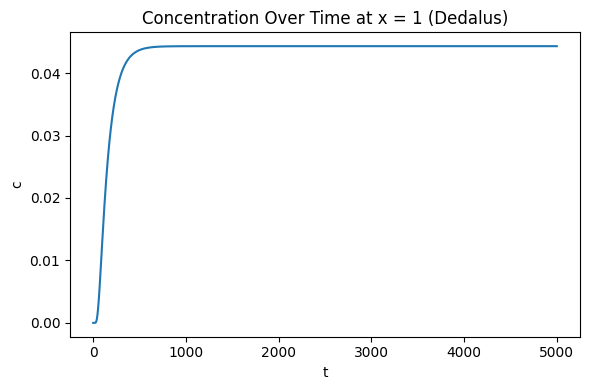

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging

# Dedalus
c_save = []
t_save = []
logger = logging.getLogger(__name__)
Nx = 1024
Lx = 2
kappa = 0.001
x_start=-Lx; x_end=Lx
xcoord = dedalus.Coordinate('x')
dist = dedalus.Distributor(xcoord, dtype=np.float64)
x_basis = dedalus.RealFourier(xcoord, size=Nx, bounds=(x_start, x_end))
x = dist.local_grid(x_basis)
c = dist.Field(name='c', bases=x_basis)
w = 0.1
c.change_scales(1)
c['g'] = np.exp(-x**2/w**2)
dx = lambda a: dedalus.Differentiate(a, xcoord)
f_x = dist.Field(bases=x_basis)
f_x['g'] = np.cos(np.pi * x / Lx)
problem = dedalus.IVP([c], namespace=locals())
problem.add_equation("dt(c) - kappa * dx(dx(c)) = f_x")
timestepper = dedalus.CNAB1
solver = problem.build_solver(timestepper)
solver.stop_sim_time = 5000
timestep = 0.1
c.change_scales(1)
x_focus = 1
x_focus_grid = np.argmin(np.abs(x-x_focus))
while solver.proceed:
    solver.step(timestep)
    if solver.iteration % 500 == 0:
        logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
    c.change_scales(1)
    c_save.append(c['g'][x_focus_grid])
    t_save.append(solver.sim_time)
c_save = np.array(c_save)
t_save = np.array(t_save)

plt.figure(figsize=(6, 4))
plt.plot(t_save, c_save)
plt.xlabel('t')
plt.ylabel('c')
plt.title('Concentration Over Time at x = 1 (Dedalus)')
plt.tight_layout()
plt.show()

# Exact Solution

In [50]:
# Find the index closest to t = 4000
t_target = 4000
t_idx = np.argmin(np.abs(t_save - t_target))

# Get the corresponding concentration value at x = 0.5
c_at_x_1_t_4000 = c_save[t_idx]

print(f"The concentration at t = {t_target} and x = 1 is approximately {c_at_x_1_t_4000:.6f}")


The concentration at t = 4000 and x = 1 is approximately 0.044311


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 9.8e+00/s


2024-12-15 23:07:35,151 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 9.8e+00/s


INFO:__main__:Iteration=500, Time=5.000000e+01, dt=1.000000e-01


2024-12-15 23:07:35,390 __main__ 0/1 INFO :: Iteration=500, Time=5.000000e+01, dt=1.000000e-01


INFO:__main__:Iteration=1000, Time=1.000000e+02, dt=1.000000e-01


2024-12-15 23:07:35,628 __main__ 0/1 INFO :: Iteration=1000, Time=1.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=1500, Time=1.500000e+02, dt=1.000000e-01


2024-12-15 23:07:35,860 __main__ 0/1 INFO :: Iteration=1500, Time=1.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=2000, Time=2.000000e+02, dt=1.000000e-01


2024-12-15 23:07:36,122 __main__ 0/1 INFO :: Iteration=2000, Time=2.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=2500, Time=2.500000e+02, dt=1.000000e-01


2024-12-15 23:07:36,372 __main__ 0/1 INFO :: Iteration=2500, Time=2.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=3000, Time=3.000000e+02, dt=1.000000e-01


2024-12-15 23:07:36,519 __main__ 0/1 INFO :: Iteration=3000, Time=3.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=3500, Time=3.500000e+02, dt=1.000000e-01


2024-12-15 23:07:36,660 __main__ 0/1 INFO :: Iteration=3500, Time=3.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=4000, Time=4.000000e+02, dt=1.000000e-01


2024-12-15 23:07:36,801 __main__ 0/1 INFO :: Iteration=4000, Time=4.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=4500, Time=4.500000e+02, dt=1.000000e-01


2024-12-15 23:07:36,949 __main__ 0/1 INFO :: Iteration=4500, Time=4.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=5000, Time=5.000000e+02, dt=1.000000e-01


2024-12-15 23:07:37,122 __main__ 0/1 INFO :: Iteration=5000, Time=5.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=5500, Time=5.500000e+02, dt=1.000000e-01


2024-12-15 23:07:37,282 __main__ 0/1 INFO :: Iteration=5500, Time=5.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=6000, Time=6.000000e+02, dt=1.000000e-01


2024-12-15 23:07:37,419 __main__ 0/1 INFO :: Iteration=6000, Time=6.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=6500, Time=6.500000e+02, dt=1.000000e-01


2024-12-15 23:07:37,557 __main__ 0/1 INFO :: Iteration=6500, Time=6.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=7000, Time=7.000000e+02, dt=1.000000e-01


2024-12-15 23:07:37,699 __main__ 0/1 INFO :: Iteration=7000, Time=7.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=7500, Time=7.500000e+02, dt=1.000000e-01


2024-12-15 23:07:37,847 __main__ 0/1 INFO :: Iteration=7500, Time=7.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=8000, Time=8.000000e+02, dt=1.000000e-01


2024-12-15 23:07:37,990 __main__ 0/1 INFO :: Iteration=8000, Time=8.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=8500, Time=8.500000e+02, dt=1.000000e-01


2024-12-15 23:07:38,174 __main__ 0/1 INFO :: Iteration=8500, Time=8.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=9000, Time=9.000000e+02, dt=1.000000e-01


2024-12-15 23:07:38,337 __main__ 0/1 INFO :: Iteration=9000, Time=9.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=9500, Time=9.500000e+02, dt=1.000000e-01


2024-12-15 23:07:38,493 __main__ 0/1 INFO :: Iteration=9500, Time=9.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=10000, Time=1.000000e+03, dt=1.000000e-01


2024-12-15 23:07:38,648 __main__ 0/1 INFO :: Iteration=10000, Time=1.000000e+03, dt=1.000000e-01


INFO:__main__:Iteration=10500, Time=1.050000e+03, dt=1.000000e-01


2024-12-15 23:07:38,800 __main__ 0/1 INFO :: Iteration=10500, Time=1.050000e+03, dt=1.000000e-01


INFO:__main__:Iteration=11000, Time=1.100000e+03, dt=1.000000e-01


2024-12-15 23:07:38,942 __main__ 0/1 INFO :: Iteration=11000, Time=1.100000e+03, dt=1.000000e-01


INFO:__main__:Iteration=11500, Time=1.150000e+03, dt=1.000000e-01


2024-12-15 23:07:39,112 __main__ 0/1 INFO :: Iteration=11500, Time=1.150000e+03, dt=1.000000e-01


INFO:__main__:Iteration=12000, Time=1.200000e+03, dt=1.000000e-01


2024-12-15 23:07:39,277 __main__ 0/1 INFO :: Iteration=12000, Time=1.200000e+03, dt=1.000000e-01


INFO:__main__:Iteration=12500, Time=1.250000e+03, dt=1.000000e-01


2024-12-15 23:07:39,422 __main__ 0/1 INFO :: Iteration=12500, Time=1.250000e+03, dt=1.000000e-01


INFO:__main__:Iteration=13000, Time=1.300000e+03, dt=1.000000e-01


2024-12-15 23:07:39,568 __main__ 0/1 INFO :: Iteration=13000, Time=1.300000e+03, dt=1.000000e-01


INFO:__main__:Iteration=13500, Time=1.350000e+03, dt=1.000000e-01


2024-12-15 23:07:39,711 __main__ 0/1 INFO :: Iteration=13500, Time=1.350000e+03, dt=1.000000e-01


INFO:__main__:Iteration=14000, Time=1.400000e+03, dt=1.000000e-01


2024-12-15 23:07:39,851 __main__ 0/1 INFO :: Iteration=14000, Time=1.400000e+03, dt=1.000000e-01


INFO:__main__:Iteration=14500, Time=1.450000e+03, dt=1.000000e-01


2024-12-15 23:07:40,002 __main__ 0/1 INFO :: Iteration=14500, Time=1.450000e+03, dt=1.000000e-01


INFO:__main__:Iteration=15000, Time=1.500000e+03, dt=1.000000e-01


2024-12-15 23:07:40,173 __main__ 0/1 INFO :: Iteration=15000, Time=1.500000e+03, dt=1.000000e-01


INFO:__main__:Iteration=15500, Time=1.550000e+03, dt=1.000000e-01


2024-12-15 23:07:40,334 __main__ 0/1 INFO :: Iteration=15500, Time=1.550000e+03, dt=1.000000e-01


INFO:__main__:Iteration=16000, Time=1.600000e+03, dt=1.000000e-01


2024-12-15 23:07:40,476 __main__ 0/1 INFO :: Iteration=16000, Time=1.600000e+03, dt=1.000000e-01


INFO:__main__:Iteration=16500, Time=1.650000e+03, dt=1.000000e-01


2024-12-15 23:07:40,617 __main__ 0/1 INFO :: Iteration=16500, Time=1.650000e+03, dt=1.000000e-01


INFO:__main__:Iteration=17000, Time=1.700000e+03, dt=1.000000e-01


2024-12-15 23:07:40,757 __main__ 0/1 INFO :: Iteration=17000, Time=1.700000e+03, dt=1.000000e-01


INFO:__main__:Iteration=17500, Time=1.750000e+03, dt=1.000000e-01


2024-12-15 23:07:40,899 __main__ 0/1 INFO :: Iteration=17500, Time=1.750000e+03, dt=1.000000e-01


INFO:__main__:Iteration=18000, Time=1.800000e+03, dt=1.000000e-01


2024-12-15 23:07:41,051 __main__ 0/1 INFO :: Iteration=18000, Time=1.800000e+03, dt=1.000000e-01


INFO:__main__:Iteration=18500, Time=1.850000e+03, dt=1.000000e-01


2024-12-15 23:07:41,209 __main__ 0/1 INFO :: Iteration=18500, Time=1.850000e+03, dt=1.000000e-01


INFO:__main__:Iteration=19000, Time=1.900000e+03, dt=1.000000e-01


2024-12-15 23:07:41,378 __main__ 0/1 INFO :: Iteration=19000, Time=1.900000e+03, dt=1.000000e-01


INFO:__main__:Iteration=19500, Time=1.950000e+03, dt=1.000000e-01


2024-12-15 23:07:41,516 __main__ 0/1 INFO :: Iteration=19500, Time=1.950000e+03, dt=1.000000e-01


INFO:__main__:Iteration=20000, Time=2.000000e+03, dt=1.000000e-01


2024-12-15 23:07:41,651 __main__ 0/1 INFO :: Iteration=20000, Time=2.000000e+03, dt=1.000000e-01


INFO:__main__:Iteration=20500, Time=2.050000e+03, dt=1.000000e-01


2024-12-15 23:07:41,791 __main__ 0/1 INFO :: Iteration=20500, Time=2.050000e+03, dt=1.000000e-01


INFO:__main__:Iteration=21000, Time=2.100000e+03, dt=1.000000e-01


2024-12-15 23:07:41,935 __main__ 0/1 INFO :: Iteration=21000, Time=2.100000e+03, dt=1.000000e-01


INFO:__main__:Iteration=21500, Time=2.150000e+03, dt=1.000000e-01


2024-12-15 23:07:42,098 __main__ 0/1 INFO :: Iteration=21500, Time=2.150000e+03, dt=1.000000e-01


INFO:__main__:Iteration=22000, Time=2.200000e+03, dt=1.000000e-01


2024-12-15 23:07:42,244 __main__ 0/1 INFO :: Iteration=22000, Time=2.200000e+03, dt=1.000000e-01


INFO:__main__:Iteration=22500, Time=2.250000e+03, dt=1.000000e-01


2024-12-15 23:07:42,397 __main__ 0/1 INFO :: Iteration=22500, Time=2.250000e+03, dt=1.000000e-01


INFO:__main__:Iteration=23000, Time=2.300000e+03, dt=1.000000e-01


2024-12-15 23:07:42,542 __main__ 0/1 INFO :: Iteration=23000, Time=2.300000e+03, dt=1.000000e-01


INFO:__main__:Iteration=23500, Time=2.350000e+03, dt=1.000000e-01


2024-12-15 23:07:42,681 __main__ 0/1 INFO :: Iteration=23500, Time=2.350000e+03, dt=1.000000e-01


INFO:__main__:Iteration=24000, Time=2.400000e+03, dt=1.000000e-01


2024-12-15 23:07:42,822 __main__ 0/1 INFO :: Iteration=24000, Time=2.400000e+03, dt=1.000000e-01


INFO:__main__:Iteration=24500, Time=2.450000e+03, dt=1.000000e-01


2024-12-15 23:07:42,970 __main__ 0/1 INFO :: Iteration=24500, Time=2.450000e+03, dt=1.000000e-01


INFO:__main__:Iteration=25000, Time=2.500000e+03, dt=1.000000e-01


2024-12-15 23:07:43,138 __main__ 0/1 INFO :: Iteration=25000, Time=2.500000e+03, dt=1.000000e-01


INFO:__main__:Iteration=25500, Time=2.550000e+03, dt=1.000000e-01


2024-12-15 23:07:43,284 __main__ 0/1 INFO :: Iteration=25500, Time=2.550000e+03, dt=1.000000e-01


INFO:__main__:Iteration=26000, Time=2.600000e+03, dt=1.000000e-01


2024-12-15 23:07:43,440 __main__ 0/1 INFO :: Iteration=26000, Time=2.600000e+03, dt=1.000000e-01


INFO:__main__:Iteration=26500, Time=2.650000e+03, dt=1.000000e-01


2024-12-15 23:07:43,577 __main__ 0/1 INFO :: Iteration=26500, Time=2.650000e+03, dt=1.000000e-01


INFO:__main__:Iteration=27000, Time=2.700000e+03, dt=1.000000e-01


2024-12-15 23:07:43,719 __main__ 0/1 INFO :: Iteration=27000, Time=2.700000e+03, dt=1.000000e-01


INFO:__main__:Iteration=27500, Time=2.750000e+03, dt=1.000000e-01


2024-12-15 23:07:43,862 __main__ 0/1 INFO :: Iteration=27500, Time=2.750000e+03, dt=1.000000e-01


INFO:__main__:Iteration=28000, Time=2.800000e+03, dt=1.000000e-01


2024-12-15 23:07:44,006 __main__ 0/1 INFO :: Iteration=28000, Time=2.800000e+03, dt=1.000000e-01


INFO:__main__:Iteration=28500, Time=2.850000e+03, dt=1.000000e-01


2024-12-15 23:07:44,174 __main__ 0/1 INFO :: Iteration=28500, Time=2.850000e+03, dt=1.000000e-01


INFO:__main__:Iteration=29000, Time=2.900000e+03, dt=1.000000e-01


2024-12-15 23:07:44,325 __main__ 0/1 INFO :: Iteration=29000, Time=2.900000e+03, dt=1.000000e-01


INFO:__main__:Iteration=29500, Time=2.950000e+03, dt=1.000000e-01


2024-12-15 23:07:44,697 __main__ 0/1 INFO :: Iteration=29500, Time=2.950000e+03, dt=1.000000e-01


INFO:__main__:Iteration=30000, Time=3.000000e+03, dt=1.000000e-01


2024-12-15 23:07:44,921 __main__ 0/1 INFO :: Iteration=30000, Time=3.000000e+03, dt=1.000000e-01


INFO:__main__:Iteration=30500, Time=3.050000e+03, dt=1.000000e-01


2024-12-15 23:07:45,079 __main__ 0/1 INFO :: Iteration=30500, Time=3.050000e+03, dt=1.000000e-01


INFO:__main__:Iteration=31000, Time=3.100000e+03, dt=1.000000e-01


2024-12-15 23:07:45,224 __main__ 0/1 INFO :: Iteration=31000, Time=3.100000e+03, dt=1.000000e-01


INFO:__main__:Iteration=31500, Time=3.150000e+03, dt=1.000000e-01


2024-12-15 23:07:45,375 __main__ 0/1 INFO :: Iteration=31500, Time=3.150000e+03, dt=1.000000e-01


INFO:__main__:Iteration=32000, Time=3.200000e+03, dt=1.000000e-01


2024-12-15 23:07:45,533 __main__ 0/1 INFO :: Iteration=32000, Time=3.200000e+03, dt=1.000000e-01


INFO:__main__:Iteration=32500, Time=3.250000e+03, dt=1.000000e-01


2024-12-15 23:07:45,674 __main__ 0/1 INFO :: Iteration=32500, Time=3.250000e+03, dt=1.000000e-01


INFO:__main__:Iteration=33000, Time=3.300000e+03, dt=1.000000e-01


2024-12-15 23:07:45,819 __main__ 0/1 INFO :: Iteration=33000, Time=3.300000e+03, dt=1.000000e-01


INFO:__main__:Iteration=33500, Time=3.350000e+03, dt=1.000000e-01


2024-12-15 23:07:45,958 __main__ 0/1 INFO :: Iteration=33500, Time=3.350000e+03, dt=1.000000e-01


INFO:__main__:Iteration=34000, Time=3.400000e+03, dt=1.000000e-01


2024-12-15 23:07:46,128 __main__ 0/1 INFO :: Iteration=34000, Time=3.400000e+03, dt=1.000000e-01


INFO:__main__:Iteration=34500, Time=3.450000e+03, dt=1.000000e-01


2024-12-15 23:07:46,276 __main__ 0/1 INFO :: Iteration=34500, Time=3.450000e+03, dt=1.000000e-01


INFO:__main__:Iteration=35000, Time=3.500000e+03, dt=1.000000e-01


2024-12-15 23:07:46,459 __main__ 0/1 INFO :: Iteration=35000, Time=3.500000e+03, dt=1.000000e-01


INFO:__main__:Iteration=35500, Time=3.550000e+03, dt=1.000000e-01


2024-12-15 23:07:46,692 __main__ 0/1 INFO :: Iteration=35500, Time=3.550000e+03, dt=1.000000e-01


INFO:__main__:Iteration=36000, Time=3.600000e+03, dt=1.000000e-01


2024-12-15 23:07:46,927 __main__ 0/1 INFO :: Iteration=36000, Time=3.600000e+03, dt=1.000000e-01


INFO:__main__:Iteration=36500, Time=3.650000e+03, dt=1.000000e-01


2024-12-15 23:07:47,166 __main__ 0/1 INFO :: Iteration=36500, Time=3.650000e+03, dt=1.000000e-01


INFO:__main__:Iteration=37000, Time=3.700000e+03, dt=1.000000e-01


2024-12-15 23:07:47,387 __main__ 0/1 INFO :: Iteration=37000, Time=3.700000e+03, dt=1.000000e-01


INFO:__main__:Iteration=37500, Time=3.750000e+03, dt=1.000000e-01


2024-12-15 23:07:47,606 __main__ 0/1 INFO :: Iteration=37500, Time=3.750000e+03, dt=1.000000e-01


INFO:__main__:Iteration=38000, Time=3.800000e+03, dt=1.000000e-01


2024-12-15 23:07:47,816 __main__ 0/1 INFO :: Iteration=38000, Time=3.800000e+03, dt=1.000000e-01


INFO:__main__:Iteration=38500, Time=3.850000e+03, dt=1.000000e-01


2024-12-15 23:07:48,024 __main__ 0/1 INFO :: Iteration=38500, Time=3.850000e+03, dt=1.000000e-01


INFO:__main__:Iteration=39000, Time=3.900000e+03, dt=1.000000e-01


2024-12-15 23:07:48,254 __main__ 0/1 INFO :: Iteration=39000, Time=3.900000e+03, dt=1.000000e-01


INFO:__main__:Iteration=39500, Time=3.950000e+03, dt=1.000000e-01


2024-12-15 23:07:48,494 __main__ 0/1 INFO :: Iteration=39500, Time=3.950000e+03, dt=1.000000e-01


INFO:__main__:Iteration=40000, Time=4.000000e+03, dt=1.000000e-01


2024-12-15 23:07:48,715 __main__ 0/1 INFO :: Iteration=40000, Time=4.000000e+03, dt=1.000000e-01


INFO:__main__:Iteration=40500, Time=4.050000e+03, dt=1.000000e-01


2024-12-15 23:07:48,957 __main__ 0/1 INFO :: Iteration=40500, Time=4.050000e+03, dt=1.000000e-01


INFO:__main__:Iteration=41000, Time=4.100000e+03, dt=1.000000e-01


2024-12-15 23:07:49,208 __main__ 0/1 INFO :: Iteration=41000, Time=4.100000e+03, dt=1.000000e-01


INFO:__main__:Iteration=41500, Time=4.150000e+03, dt=1.000000e-01


2024-12-15 23:07:49,438 __main__ 0/1 INFO :: Iteration=41500, Time=4.150000e+03, dt=1.000000e-01


INFO:__main__:Iteration=42000, Time=4.200000e+03, dt=1.000000e-01


2024-12-15 23:07:49,694 __main__ 0/1 INFO :: Iteration=42000, Time=4.200000e+03, dt=1.000000e-01


INFO:__main__:Iteration=42500, Time=4.250000e+03, dt=1.000000e-01


2024-12-15 23:07:49,933 __main__ 0/1 INFO :: Iteration=42500, Time=4.250000e+03, dt=1.000000e-01


INFO:__main__:Iteration=43000, Time=4.300000e+03, dt=1.000000e-01


2024-12-15 23:07:50,091 __main__ 0/1 INFO :: Iteration=43000, Time=4.300000e+03, dt=1.000000e-01


INFO:__main__:Iteration=43500, Time=4.350000e+03, dt=1.000000e-01


2024-12-15 23:07:50,236 __main__ 0/1 INFO :: Iteration=43500, Time=4.350000e+03, dt=1.000000e-01


INFO:__main__:Iteration=44000, Time=4.400000e+03, dt=1.000000e-01


2024-12-15 23:07:50,382 __main__ 0/1 INFO :: Iteration=44000, Time=4.400000e+03, dt=1.000000e-01


INFO:__main__:Iteration=44500, Time=4.450000e+03, dt=1.000000e-01


2024-12-15 23:07:50,525 __main__ 0/1 INFO :: Iteration=44500, Time=4.450000e+03, dt=1.000000e-01


INFO:__main__:Iteration=45000, Time=4.500000e+03, dt=1.000000e-01


2024-12-15 23:07:50,679 __main__ 0/1 INFO :: Iteration=45000, Time=4.500000e+03, dt=1.000000e-01


INFO:__main__:Iteration=45500, Time=4.550000e+03, dt=1.000000e-01


2024-12-15 23:07:50,815 __main__ 0/1 INFO :: Iteration=45500, Time=4.550000e+03, dt=1.000000e-01


INFO:__main__:Iteration=46000, Time=4.600000e+03, dt=1.000000e-01


2024-12-15 23:07:50,961 __main__ 0/1 INFO :: Iteration=46000, Time=4.600000e+03, dt=1.000000e-01


INFO:__main__:Iteration=46500, Time=4.650000e+03, dt=1.000000e-01


2024-12-15 23:07:51,140 __main__ 0/1 INFO :: Iteration=46500, Time=4.650000e+03, dt=1.000000e-01


INFO:__main__:Iteration=47000, Time=4.700000e+03, dt=1.000000e-01


2024-12-15 23:07:51,291 __main__ 0/1 INFO :: Iteration=47000, Time=4.700000e+03, dt=1.000000e-01


INFO:__main__:Iteration=47500, Time=4.750000e+03, dt=1.000000e-01


2024-12-15 23:07:51,428 __main__ 0/1 INFO :: Iteration=47500, Time=4.750000e+03, dt=1.000000e-01


INFO:__main__:Iteration=48000, Time=4.800000e+03, dt=1.000000e-01


2024-12-15 23:07:51,573 __main__ 0/1 INFO :: Iteration=48000, Time=4.800000e+03, dt=1.000000e-01


INFO:__main__:Iteration=48500, Time=4.850000e+03, dt=1.000000e-01


2024-12-15 23:07:51,732 __main__ 0/1 INFO :: Iteration=48500, Time=4.850000e+03, dt=1.000000e-01


INFO:__main__:Iteration=49000, Time=4.900000e+03, dt=1.000000e-01


2024-12-15 23:07:51,882 __main__ 0/1 INFO :: Iteration=49000, Time=4.900000e+03, dt=1.000000e-01


INFO:__main__:Iteration=49500, Time=4.950000e+03, dt=1.000000e-01


2024-12-15 23:07:52,034 __main__ 0/1 INFO :: Iteration=49500, Time=4.950000e+03, dt=1.000000e-01


INFO:__main__:Iteration=50000, Time=5.000000e+03, dt=1.000000e-01


2024-12-15 23:07:52,189 __main__ 0/1 INFO :: Iteration=50000, Time=5.000000e+03, dt=1.000000e-01


INFO:solvers:Simulation stop time reached.


2024-12-15 23:07:52,193 solvers 0/1 INFO :: Simulation stop time reached.


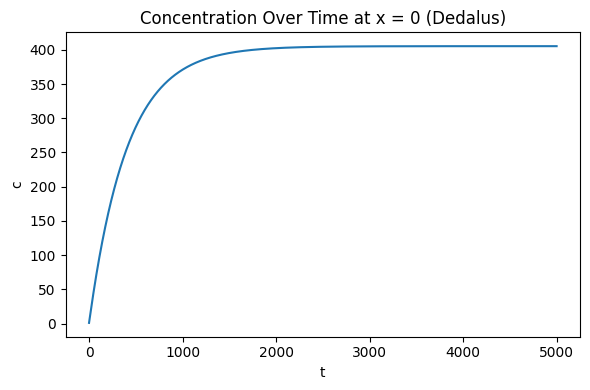

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging

# Dedalus
c_save = []
t_save = []
logger = logging.getLogger(__name__)
Nx = 1024
Lx = 2
kappa = 0.001
x_start=-Lx; x_end=Lx
xcoord = dedalus.Coordinate('x')
dist = dedalus.Distributor(xcoord, dtype=np.float64)
x_basis = dedalus.RealFourier(xcoord, size=Nx, bounds=(x_start, x_end))
x = dist.local_grid(x_basis)
c = dist.Field(name='c', bases=x_basis)
w = 0.1
c.change_scales(1)
c['g'] = np.exp(-x**2/w**2)
dx = lambda a: dedalus.Differentiate(a, xcoord)
f_x = dist.Field(bases=x_basis)
f_x['g'] = np.cos(np.pi * x / Lx)
problem = dedalus.IVP([c], namespace=locals())
problem.add_equation("dt(c) - kappa * dx(dx(c)) = f_x")
timestepper = dedalus.CNAB1
solver = problem.build_solver(timestepper)
solver.stop_sim_time = 5000
timestep = 0.1
c.change_scales(1)
x_focus = 0
x_focus_grid = np.argmin(np.abs(x-x_focus))
while solver.proceed:
    solver.step(timestep)
    if solver.iteration % 500 == 0:
        logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
    c.change_scales(1)
    c_save.append(c['g'][x_focus_grid])
    t_save.append(solver.sim_time)
c_save = np.array(c_save)
t_save = np.array(t_save)

plt.figure(figsize=(6, 4))
plt.plot(t_save, c_save)
plt.xlabel('t')
plt.ylabel('c')
plt.title('Concentration Over Time at x = 0 (Dedalus)')
plt.tight_layout()
plt.show()

# Exact Solution

In [43]:
# Find the index closest to t = 4000
t_target = 4000
t_idx = np.argmin(np.abs(t_save - t_target))

# Get the corresponding concentration value at x = 0
c_at_x_0_t_4000 = c_save[t_idx]

print(f"The concentration at t = {t_target} and x = 0 is approximately {c_at_x_0_t_4000:.6f}")


The concentration at t = 4000 and x = 0 is approximately 405.308088


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+01/s


2024-12-15 23:07:52,610 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+01/s


INFO:__main__:Iteration=500, Time=5.000000e+01, dt=1.000000e-01


2024-12-15 23:07:52,769 __main__ 0/1 INFO :: Iteration=500, Time=5.000000e+01, dt=1.000000e-01


INFO:__main__:Iteration=1000, Time=1.000000e+02, dt=1.000000e-01


2024-12-15 23:07:52,923 __main__ 0/1 INFO :: Iteration=1000, Time=1.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=1500, Time=1.500000e+02, dt=1.000000e-01


2024-12-15 23:07:53,089 __main__ 0/1 INFO :: Iteration=1500, Time=1.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=2000, Time=2.000000e+02, dt=1.000000e-01


2024-12-15 23:07:53,262 __main__ 0/1 INFO :: Iteration=2000, Time=2.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=2500, Time=2.500000e+02, dt=1.000000e-01


2024-12-15 23:07:53,413 __main__ 0/1 INFO :: Iteration=2500, Time=2.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=3000, Time=3.000000e+02, dt=1.000000e-01


2024-12-15 23:07:53,557 __main__ 0/1 INFO :: Iteration=3000, Time=3.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=3500, Time=3.500000e+02, dt=1.000000e-01


2024-12-15 23:07:53,712 __main__ 0/1 INFO :: Iteration=3500, Time=3.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=4000, Time=4.000000e+02, dt=1.000000e-01


2024-12-15 23:07:53,873 __main__ 0/1 INFO :: Iteration=4000, Time=4.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=4500, Time=4.500000e+02, dt=1.000000e-01


2024-12-15 23:07:54,026 __main__ 0/1 INFO :: Iteration=4500, Time=4.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=5000, Time=5.000000e+02, dt=1.000000e-01


2024-12-15 23:07:54,195 __main__ 0/1 INFO :: Iteration=5000, Time=5.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=5500, Time=5.500000e+02, dt=1.000000e-01


2024-12-15 23:07:54,361 __main__ 0/1 INFO :: Iteration=5500, Time=5.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=6000, Time=6.000000e+02, dt=1.000000e-01


2024-12-15 23:07:54,505 __main__ 0/1 INFO :: Iteration=6000, Time=6.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=6500, Time=6.500000e+02, dt=1.000000e-01


2024-12-15 23:07:54,647 __main__ 0/1 INFO :: Iteration=6500, Time=6.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=7000, Time=7.000000e+02, dt=1.000000e-01


2024-12-15 23:07:54,806 __main__ 0/1 INFO :: Iteration=7000, Time=7.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=7500, Time=7.500000e+02, dt=1.000000e-01


2024-12-15 23:07:54,961 __main__ 0/1 INFO :: Iteration=7500, Time=7.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=8000, Time=8.000000e+02, dt=1.000000e-01


2024-12-15 23:07:55,124 __main__ 0/1 INFO :: Iteration=8000, Time=8.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=8500, Time=8.500000e+02, dt=1.000000e-01


2024-12-15 23:07:55,272 __main__ 0/1 INFO :: Iteration=8500, Time=8.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=9000, Time=9.000000e+02, dt=1.000000e-01


2024-12-15 23:07:55,435 __main__ 0/1 INFO :: Iteration=9000, Time=9.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=9500, Time=9.500000e+02, dt=1.000000e-01


2024-12-15 23:07:55,583 __main__ 0/1 INFO :: Iteration=9500, Time=9.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=10000, Time=1.000000e+03, dt=1.000000e-01


2024-12-15 23:07:55,728 __main__ 0/1 INFO :: Iteration=10000, Time=1.000000e+03, dt=1.000000e-01


INFO:__main__:Iteration=10500, Time=1.050000e+03, dt=1.000000e-01


2024-12-15 23:07:55,886 __main__ 0/1 INFO :: Iteration=10500, Time=1.050000e+03, dt=1.000000e-01


INFO:__main__:Iteration=11000, Time=1.100000e+03, dt=1.000000e-01


2024-12-15 23:07:56,044 __main__ 0/1 INFO :: Iteration=11000, Time=1.100000e+03, dt=1.000000e-01


INFO:__main__:Iteration=11500, Time=1.150000e+03, dt=1.000000e-01


2024-12-15 23:07:56,221 __main__ 0/1 INFO :: Iteration=11500, Time=1.150000e+03, dt=1.000000e-01


INFO:__main__:Iteration=12000, Time=1.200000e+03, dt=1.000000e-01


2024-12-15 23:07:56,378 __main__ 0/1 INFO :: Iteration=12000, Time=1.200000e+03, dt=1.000000e-01


INFO:__main__:Iteration=12500, Time=1.250000e+03, dt=1.000000e-01


2024-12-15 23:07:56,534 __main__ 0/1 INFO :: Iteration=12500, Time=1.250000e+03, dt=1.000000e-01


INFO:__main__:Iteration=13000, Time=1.300000e+03, dt=1.000000e-01


2024-12-15 23:07:56,697 __main__ 0/1 INFO :: Iteration=13000, Time=1.300000e+03, dt=1.000000e-01


INFO:__main__:Iteration=13500, Time=1.350000e+03, dt=1.000000e-01


2024-12-15 23:07:56,865 __main__ 0/1 INFO :: Iteration=13500, Time=1.350000e+03, dt=1.000000e-01


INFO:__main__:Iteration=14000, Time=1.400000e+03, dt=1.000000e-01


2024-12-15 23:07:57,025 __main__ 0/1 INFO :: Iteration=14000, Time=1.400000e+03, dt=1.000000e-01


INFO:__main__:Iteration=14500, Time=1.450000e+03, dt=1.000000e-01


2024-12-15 23:07:57,204 __main__ 0/1 INFO :: Iteration=14500, Time=1.450000e+03, dt=1.000000e-01


INFO:__main__:Iteration=15000, Time=1.500000e+03, dt=1.000000e-01


2024-12-15 23:07:57,372 __main__ 0/1 INFO :: Iteration=15000, Time=1.500000e+03, dt=1.000000e-01


INFO:__main__:Iteration=15500, Time=1.550000e+03, dt=1.000000e-01


2024-12-15 23:07:57,528 __main__ 0/1 INFO :: Iteration=15500, Time=1.550000e+03, dt=1.000000e-01


INFO:__main__:Iteration=16000, Time=1.600000e+03, dt=1.000000e-01


2024-12-15 23:07:57,688 __main__ 0/1 INFO :: Iteration=16000, Time=1.600000e+03, dt=1.000000e-01


INFO:__main__:Iteration=16500, Time=1.650000e+03, dt=1.000000e-01


2024-12-15 23:07:57,857 __main__ 0/1 INFO :: Iteration=16500, Time=1.650000e+03, dt=1.000000e-01


INFO:__main__:Iteration=17000, Time=1.700000e+03, dt=1.000000e-01


2024-12-15 23:07:58,026 __main__ 0/1 INFO :: Iteration=17000, Time=1.700000e+03, dt=1.000000e-01


INFO:__main__:Iteration=17500, Time=1.750000e+03, dt=1.000000e-01


2024-12-15 23:07:58,199 __main__ 0/1 INFO :: Iteration=17500, Time=1.750000e+03, dt=1.000000e-01


INFO:__main__:Iteration=18000, Time=1.800000e+03, dt=1.000000e-01


2024-12-15 23:07:58,357 __main__ 0/1 INFO :: Iteration=18000, Time=1.800000e+03, dt=1.000000e-01


INFO:__main__:Iteration=18500, Time=1.850000e+03, dt=1.000000e-01


2024-12-15 23:07:58,520 __main__ 0/1 INFO :: Iteration=18500, Time=1.850000e+03, dt=1.000000e-01


INFO:__main__:Iteration=19000, Time=1.900000e+03, dt=1.000000e-01


2024-12-15 23:07:58,677 __main__ 0/1 INFO :: Iteration=19000, Time=1.900000e+03, dt=1.000000e-01


INFO:__main__:Iteration=19500, Time=1.950000e+03, dt=1.000000e-01


2024-12-15 23:07:58,836 __main__ 0/1 INFO :: Iteration=19500, Time=1.950000e+03, dt=1.000000e-01


INFO:__main__:Iteration=20000, Time=2.000000e+03, dt=1.000000e-01


2024-12-15 23:07:59,012 __main__ 0/1 INFO :: Iteration=20000, Time=2.000000e+03, dt=1.000000e-01


INFO:__main__:Iteration=20500, Time=2.050000e+03, dt=1.000000e-01


2024-12-15 23:07:59,188 __main__ 0/1 INFO :: Iteration=20500, Time=2.050000e+03, dt=1.000000e-01


INFO:__main__:Iteration=21000, Time=2.100000e+03, dt=1.000000e-01


2024-12-15 23:07:59,357 __main__ 0/1 INFO :: Iteration=21000, Time=2.100000e+03, dt=1.000000e-01


INFO:__main__:Iteration=21500, Time=2.150000e+03, dt=1.000000e-01


2024-12-15 23:07:59,517 __main__ 0/1 INFO :: Iteration=21500, Time=2.150000e+03, dt=1.000000e-01


INFO:__main__:Iteration=22000, Time=2.200000e+03, dt=1.000000e-01


2024-12-15 23:07:59,674 __main__ 0/1 INFO :: Iteration=22000, Time=2.200000e+03, dt=1.000000e-01


INFO:__main__:Iteration=22500, Time=2.250000e+03, dt=1.000000e-01


2024-12-15 23:07:59,834 __main__ 0/1 INFO :: Iteration=22500, Time=2.250000e+03, dt=1.000000e-01


INFO:__main__:Iteration=23000, Time=2.300000e+03, dt=1.000000e-01


2024-12-15 23:08:00,051 __main__ 0/1 INFO :: Iteration=23000, Time=2.300000e+03, dt=1.000000e-01


INFO:__main__:Iteration=23500, Time=2.350000e+03, dt=1.000000e-01


2024-12-15 23:08:00,316 __main__ 0/1 INFO :: Iteration=23500, Time=2.350000e+03, dt=1.000000e-01


INFO:__main__:Iteration=24000, Time=2.400000e+03, dt=1.000000e-01


2024-12-15 23:08:00,558 __main__ 0/1 INFO :: Iteration=24000, Time=2.400000e+03, dt=1.000000e-01


INFO:__main__:Iteration=24500, Time=2.450000e+03, dt=1.000000e-01


2024-12-15 23:08:00,787 __main__ 0/1 INFO :: Iteration=24500, Time=2.450000e+03, dt=1.000000e-01


INFO:__main__:Iteration=25000, Time=2.500000e+03, dt=1.000000e-01


2024-12-15 23:08:01,025 __main__ 0/1 INFO :: Iteration=25000, Time=2.500000e+03, dt=1.000000e-01


INFO:__main__:Iteration=25500, Time=2.550000e+03, dt=1.000000e-01


2024-12-15 23:08:01,263 __main__ 0/1 INFO :: Iteration=25500, Time=2.550000e+03, dt=1.000000e-01


INFO:__main__:Iteration=26000, Time=2.600000e+03, dt=1.000000e-01


2024-12-15 23:08:01,485 __main__ 0/1 INFO :: Iteration=26000, Time=2.600000e+03, dt=1.000000e-01


INFO:__main__:Iteration=26500, Time=2.650000e+03, dt=1.000000e-01


2024-12-15 23:08:01,703 __main__ 0/1 INFO :: Iteration=26500, Time=2.650000e+03, dt=1.000000e-01


INFO:__main__:Iteration=27000, Time=2.700000e+03, dt=1.000000e-01


2024-12-15 23:08:01,954 __main__ 0/1 INFO :: Iteration=27000, Time=2.700000e+03, dt=1.000000e-01


INFO:__main__:Iteration=27500, Time=2.750000e+03, dt=1.000000e-01


2024-12-15 23:08:02,218 __main__ 0/1 INFO :: Iteration=27500, Time=2.750000e+03, dt=1.000000e-01


INFO:__main__:Iteration=28000, Time=2.800000e+03, dt=1.000000e-01


2024-12-15 23:08:02,491 __main__ 0/1 INFO :: Iteration=28000, Time=2.800000e+03, dt=1.000000e-01


INFO:__main__:Iteration=28500, Time=2.850000e+03, dt=1.000000e-01


2024-12-15 23:08:02,744 __main__ 0/1 INFO :: Iteration=28500, Time=2.850000e+03, dt=1.000000e-01


INFO:__main__:Iteration=29000, Time=2.900000e+03, dt=1.000000e-01


2024-12-15 23:08:02,983 __main__ 0/1 INFO :: Iteration=29000, Time=2.900000e+03, dt=1.000000e-01


INFO:__main__:Iteration=29500, Time=2.950000e+03, dt=1.000000e-01


2024-12-15 23:08:03,259 __main__ 0/1 INFO :: Iteration=29500, Time=2.950000e+03, dt=1.000000e-01


INFO:__main__:Iteration=30000, Time=3.000000e+03, dt=1.000000e-01


2024-12-15 23:08:03,502 __main__ 0/1 INFO :: Iteration=30000, Time=3.000000e+03, dt=1.000000e-01


INFO:__main__:Iteration=30500, Time=3.050000e+03, dt=1.000000e-01


2024-12-15 23:08:03,754 __main__ 0/1 INFO :: Iteration=30500, Time=3.050000e+03, dt=1.000000e-01


INFO:__main__:Iteration=31000, Time=3.100000e+03, dt=1.000000e-01


2024-12-15 23:08:03,911 __main__ 0/1 INFO :: Iteration=31000, Time=3.100000e+03, dt=1.000000e-01


INFO:__main__:Iteration=31500, Time=3.150000e+03, dt=1.000000e-01


2024-12-15 23:08:04,089 __main__ 0/1 INFO :: Iteration=31500, Time=3.150000e+03, dt=1.000000e-01


INFO:__main__:Iteration=32000, Time=3.200000e+03, dt=1.000000e-01


2024-12-15 23:08:04,259 __main__ 0/1 INFO :: Iteration=32000, Time=3.200000e+03, dt=1.000000e-01


INFO:__main__:Iteration=32500, Time=3.250000e+03, dt=1.000000e-01


2024-12-15 23:08:04,418 __main__ 0/1 INFO :: Iteration=32500, Time=3.250000e+03, dt=1.000000e-01


INFO:__main__:Iteration=33000, Time=3.300000e+03, dt=1.000000e-01


2024-12-15 23:08:04,582 __main__ 0/1 INFO :: Iteration=33000, Time=3.300000e+03, dt=1.000000e-01


INFO:__main__:Iteration=33500, Time=3.350000e+03, dt=1.000000e-01


2024-12-15 23:08:04,742 __main__ 0/1 INFO :: Iteration=33500, Time=3.350000e+03, dt=1.000000e-01


INFO:__main__:Iteration=34000, Time=3.400000e+03, dt=1.000000e-01


2024-12-15 23:08:04,895 __main__ 0/1 INFO :: Iteration=34000, Time=3.400000e+03, dt=1.000000e-01


INFO:__main__:Iteration=34500, Time=3.450000e+03, dt=1.000000e-01


2024-12-15 23:08:05,065 __main__ 0/1 INFO :: Iteration=34500, Time=3.450000e+03, dt=1.000000e-01


INFO:__main__:Iteration=35000, Time=3.500000e+03, dt=1.000000e-01


2024-12-15 23:08:05,247 __main__ 0/1 INFO :: Iteration=35000, Time=3.500000e+03, dt=1.000000e-01


INFO:__main__:Iteration=35500, Time=3.550000e+03, dt=1.000000e-01


2024-12-15 23:08:05,405 __main__ 0/1 INFO :: Iteration=35500, Time=3.550000e+03, dt=1.000000e-01


INFO:__main__:Iteration=36000, Time=3.600000e+03, dt=1.000000e-01


2024-12-15 23:08:05,567 __main__ 0/1 INFO :: Iteration=36000, Time=3.600000e+03, dt=1.000000e-01


INFO:__main__:Iteration=36500, Time=3.650000e+03, dt=1.000000e-01


2024-12-15 23:08:05,720 __main__ 0/1 INFO :: Iteration=36500, Time=3.650000e+03, dt=1.000000e-01


INFO:__main__:Iteration=37000, Time=3.700000e+03, dt=1.000000e-01


2024-12-15 23:08:05,872 __main__ 0/1 INFO :: Iteration=37000, Time=3.700000e+03, dt=1.000000e-01


INFO:__main__:Iteration=37500, Time=3.750000e+03, dt=1.000000e-01


2024-12-15 23:08:06,042 __main__ 0/1 INFO :: Iteration=37500, Time=3.750000e+03, dt=1.000000e-01


INFO:__main__:Iteration=38000, Time=3.800000e+03, dt=1.000000e-01


2024-12-15 23:08:06,213 __main__ 0/1 INFO :: Iteration=38000, Time=3.800000e+03, dt=1.000000e-01


INFO:__main__:Iteration=38500, Time=3.850000e+03, dt=1.000000e-01


2024-12-15 23:08:06,403 __main__ 0/1 INFO :: Iteration=38500, Time=3.850000e+03, dt=1.000000e-01


INFO:__main__:Iteration=39000, Time=3.900000e+03, dt=1.000000e-01


2024-12-15 23:08:06,561 __main__ 0/1 INFO :: Iteration=39000, Time=3.900000e+03, dt=1.000000e-01


INFO:__main__:Iteration=39500, Time=3.950000e+03, dt=1.000000e-01


2024-12-15 23:08:06,718 __main__ 0/1 INFO :: Iteration=39500, Time=3.950000e+03, dt=1.000000e-01


INFO:__main__:Iteration=40000, Time=4.000000e+03, dt=1.000000e-01


2024-12-15 23:08:06,882 __main__ 0/1 INFO :: Iteration=40000, Time=4.000000e+03, dt=1.000000e-01


INFO:__main__:Iteration=40500, Time=4.050000e+03, dt=1.000000e-01


2024-12-15 23:08:07,054 __main__ 0/1 INFO :: Iteration=40500, Time=4.050000e+03, dt=1.000000e-01


INFO:__main__:Iteration=41000, Time=4.100000e+03, dt=1.000000e-01


2024-12-15 23:08:07,239 __main__ 0/1 INFO :: Iteration=41000, Time=4.100000e+03, dt=1.000000e-01


INFO:__main__:Iteration=41500, Time=4.150000e+03, dt=1.000000e-01


2024-12-15 23:08:07,445 __main__ 0/1 INFO :: Iteration=41500, Time=4.150000e+03, dt=1.000000e-01


INFO:__main__:Iteration=42000, Time=4.200000e+03, dt=1.000000e-01


2024-12-15 23:08:07,613 __main__ 0/1 INFO :: Iteration=42000, Time=4.200000e+03, dt=1.000000e-01


INFO:__main__:Iteration=42500, Time=4.250000e+03, dt=1.000000e-01


2024-12-15 23:08:07,777 __main__ 0/1 INFO :: Iteration=42500, Time=4.250000e+03, dt=1.000000e-01


INFO:__main__:Iteration=43000, Time=4.300000e+03, dt=1.000000e-01


2024-12-15 23:08:07,949 __main__ 0/1 INFO :: Iteration=43000, Time=4.300000e+03, dt=1.000000e-01


INFO:__main__:Iteration=43500, Time=4.350000e+03, dt=1.000000e-01


2024-12-15 23:08:08,127 __main__ 0/1 INFO :: Iteration=43500, Time=4.350000e+03, dt=1.000000e-01


INFO:__main__:Iteration=44000, Time=4.400000e+03, dt=1.000000e-01


2024-12-15 23:08:08,288 __main__ 0/1 INFO :: Iteration=44000, Time=4.400000e+03, dt=1.000000e-01


INFO:__main__:Iteration=44500, Time=4.450000e+03, dt=1.000000e-01


2024-12-15 23:08:08,467 __main__ 0/1 INFO :: Iteration=44500, Time=4.450000e+03, dt=1.000000e-01


INFO:__main__:Iteration=45000, Time=4.500000e+03, dt=1.000000e-01


2024-12-15 23:08:08,632 __main__ 0/1 INFO :: Iteration=45000, Time=4.500000e+03, dt=1.000000e-01


INFO:__main__:Iteration=45500, Time=4.550000e+03, dt=1.000000e-01


2024-12-15 23:08:08,794 __main__ 0/1 INFO :: Iteration=45500, Time=4.550000e+03, dt=1.000000e-01


INFO:__main__:Iteration=46000, Time=4.600000e+03, dt=1.000000e-01


2024-12-15 23:08:08,957 __main__ 0/1 INFO :: Iteration=46000, Time=4.600000e+03, dt=1.000000e-01


INFO:__main__:Iteration=46500, Time=4.650000e+03, dt=1.000000e-01


2024-12-15 23:08:09,138 __main__ 0/1 INFO :: Iteration=46500, Time=4.650000e+03, dt=1.000000e-01


INFO:__main__:Iteration=47000, Time=4.700000e+03, dt=1.000000e-01


2024-12-15 23:08:09,316 __main__ 0/1 INFO :: Iteration=47000, Time=4.700000e+03, dt=1.000000e-01


INFO:__main__:Iteration=47500, Time=4.750000e+03, dt=1.000000e-01


2024-12-15 23:08:09,512 __main__ 0/1 INFO :: Iteration=47500, Time=4.750000e+03, dt=1.000000e-01


INFO:__main__:Iteration=48000, Time=4.800000e+03, dt=1.000000e-01


2024-12-15 23:08:09,670 __main__ 0/1 INFO :: Iteration=48000, Time=4.800000e+03, dt=1.000000e-01


INFO:__main__:Iteration=48500, Time=4.850000e+03, dt=1.000000e-01


2024-12-15 23:08:09,831 __main__ 0/1 INFO :: Iteration=48500, Time=4.850000e+03, dt=1.000000e-01


INFO:__main__:Iteration=49000, Time=4.900000e+03, dt=1.000000e-01


2024-12-15 23:08:10,002 __main__ 0/1 INFO :: Iteration=49000, Time=4.900000e+03, dt=1.000000e-01


INFO:__main__:Iteration=49500, Time=4.950000e+03, dt=1.000000e-01


2024-12-15 23:08:10,200 __main__ 0/1 INFO :: Iteration=49500, Time=4.950000e+03, dt=1.000000e-01


INFO:__main__:Iteration=50000, Time=5.000000e+03, dt=1.000000e-01


2024-12-15 23:08:10,354 __main__ 0/1 INFO :: Iteration=50000, Time=5.000000e+03, dt=1.000000e-01


INFO:solvers:Simulation stop time reached.


2024-12-15 23:08:10,358 solvers 0/1 INFO :: Simulation stop time reached.


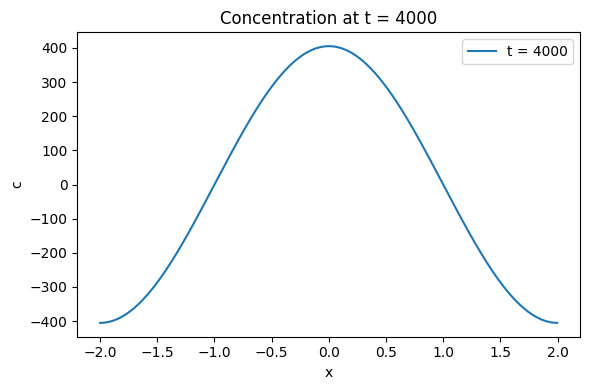

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging

# Dedalus setup
logger = logging.getLogger(__name__)
Nx = 1024
Lx = 2
kappa = 0.001
x_start = -Lx
x_end = Lx

# Create coordinate, basis, and distributor
xcoord = dedalus.Coordinate('x')
dist = dedalus.Distributor(xcoord, dtype=np.float64)
x_basis = dedalus.RealFourier(xcoord, size=Nx, bounds=(x_start, x_end))
x = dist.local_grid(x_basis)

# Set initial conditions
c = dist.Field(name='c', bases=x_basis)
w = 0.1
c.change_scales(1)
c['g'] = np.exp(-x**2 / w**2)

# Define operators and forcing
dx = lambda a: dedalus.Differentiate(a, xcoord)
f_x = dist.Field(bases=x_basis)
f_x['g'] = np.cos(np.pi * x / Lx)

# Specify problem
problem = dedalus.IVP([c], namespace=locals())
problem.add_equation("dt(c) - kappa * dx(dx(c)) = f_x")
timestepper = dedalus.CNAB1
solver = problem.build_solver(timestepper)

# Set simulation parameters
solver.stop_sim_time = 5000
timestep = 0.1

# Save data
c_save_all = []
t_save = []
while solver.proceed:
    solver.step(timestep)
    if solver.iteration % 500 == 0:
        logger.info('Iteration=%i, Time=%e, dt=%e' % (solver.iteration, solver.sim_time, timestep))
    c.change_scales(1)
    c_save_all.append(np.copy(c['g']))
    t_save.append(solver.sim_time)

# Convert saved data to arrays
c_save_all = np.array(c_save_all)
t_save = np.array(t_save)

# Find the index closest to t = 4000
t_target = 4000
t_idx = np.argmin(np.abs(t_save - t_target))
c_at_t = c_save_all[t_idx]

# Plot concentration at t = 4,000 for all x
plt.figure(figsize=(6, 4))
plt.plot(x, c_at_t, label=f't = {t_target}')
plt.xlabel('x')
plt.ylabel('c')
plt.title(f'Concentration at t = {t_target}')
plt.legend()
plt.tight_layout()
plt.show()


### 5.2 Variable difusivity

In some applications of the diffusion equation, the diffusivity varies in space. This happens, for example, in the movement of pollution in groundwater flowing through soil of variable porosity, or the mixing of tracers due to turbulence in the ocean (which we will explore in detail in Project 2).

In the code cell below, write a Dedalus script that solves the following equation:

$$\partial_t c - \partial_x(\kappa (x) \partial_x c) = 0$$

where

$$\kappa(x)=\kappa_0(0.1 + tanh(x/0.1)+1)/2$$

and $\kappa_0=0.001$. It is fine to start by copying the code in the previous cell and changing the problem equation appropriately.

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s


2024-12-15 23:08:11,684 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s


INFO:solvers:Simulation stop time reached.


2024-12-15 23:08:12,097 solvers 0/1 INFO :: Simulation stop time reached.


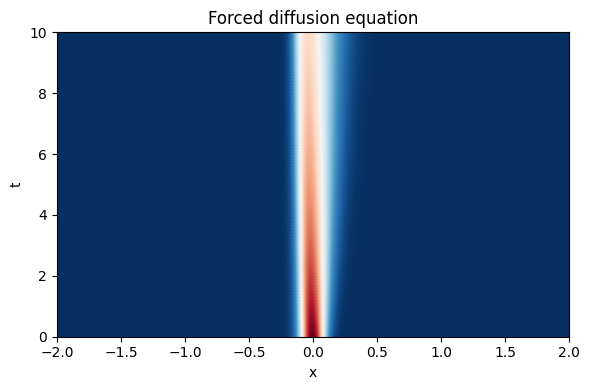

In [46]:
# Load the required packages (these were loaded above and are inluded here for completeness)
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# This script solves the forced diffusion equation with Dedlaus

# Set some parameters for the problem to be solved
Nx = 1024 # The number of gridpoints. Note that Fourier transforms are more efficient if this is a power of 2
Lx = 2; # The domain size in x.  This should be large enough so that the solution goes to zero at the endpoints.
x_start=-Lx; x_end=Lx # The starting and ending bounds on x
kappa_0 = 0.001 # set the diffusivity

# Create an x-coordinate, a corresponding basis, and a distributor
xcoord = dedalus.Coordinate('x')
dist = dedalus.Distributor(xcoord, dtype=np.float64) # No mesh for serial / automatic parallelization
x_basis = dedalus.RealFourier(xcoord, size=Nx, bounds=(x_start, x_end))
x = dist.local_grid(x_basis)
kappa = dist.Field(name = 'kappa', bases = x_basis)
kappa['g'] = kappa_0 * (0.1 + np.tanh(x/0.1) + 1) * 0.5

# Set initial conditions
c = dist.Field(name='c', bases=x_basis)
w = 0.1 # Set the width of the initial Gaussian
c.change_scales(1) # Set values on regular grid
c['g'] = np.exp(-x**2/w**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)

# Operators
dx = lambda a: dedalus.Differentiate(a, xcoord) # Define the derivative (d/dx) operator

# Specify the problem
problem = dedalus.IVP([c], namespace=locals()) # Initial value problem, including all local variables
problem.add_equation("dt(c) - dx(kappa * dx(c)) = 0"); # Write out the equation to be solved

timestepper = dedalus.CNAB1
solver = problem.build_solver(timestepper)

solver.stop_sim_time = 10 # Stop at 10 simulation time units

# Main loop
timestep = 0.1
c.change_scales(1)
c_save = [np.copy(c['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
while solver.proceed:
    solver.step(timestep)
    if solver.iteration % 500 == 0: # Every 500 timesteps, print a message to the screen with the progress
        logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
    c.change_scales(1)
    c_save.append(np.copy(c['g']))
    t_save.append(solver.sim_time)

# Plot
plt.figure(figsize=(6, 4))
plt.pcolormesh(x.ravel(), np.array(t_save), np.array(c_save), cmap='RdBu_r', shading='gouraud', rasterized=True)#, clim=(-1, 1))
plt.xlim(x_start, x_end)
plt.ylim(0, solver.stop_sim_time)
plt.xlabel('x')
plt.ylabel('t')
plt.title('Forced diffusion equation')
plt.tight_layout()

Explore the behaviour of the solution as you vary the parameters associated with $\kappa(x)$. Comment on your observations below (~1 paragraph)

If kappa gets 10 times larger, the new graph shows a different pattern, where the substance whose concentration is in question spreads in the x-direction more quickly than it does with the original kappa value. This indicates that the substance does not stay at $x = 0$ as long as it does with the original kappa value. When changing the denominator 0.1 to a smaller value in $tanh(x/0.1)$, I can see higher concentrations closer to $x = 0$ for every $t$, as $tanh(x/n)$, where $n < 0.1$, reaches 1 and -1 faster than $tanh(x/0.1)$ with an increasing and decreasing x, respectively.

## 6. Optional further investigations

* Try writing a Dedalus script to solve the 2D diffusion equation as an initial value problem.  You can look ahead to the the example at the end of the Project 2 notebook for some guidance (but remove the advection term). I would suggest using a Fourier/Fourier basis for this.

* Consider how you might go about discretizing a 2D diffusion equation using finite differences.  What form would the matrix M have?
